In [1]:
import seaborn
import random
import numpy as np
import os 
import re
import shutil

import sentencepiece as spm
from tqdm.notebook import tqdm
import tensorflow as tf

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [2]:
%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# Step 1. 데이터 다운로드

In [3]:
!ln -s ~/data ~/aiffel/transformer/data

!ls ~/aiffel/transformer/data

ln: failed to create symbolic link '/aiffel/aiffel/transformer/data/data': Read-only file system
korean-english-park.train.en  korean-english-park.train.ko


In [4]:
if not os.path.exists('./data'):
    os.mkdir('./data')

In [5]:
data_dir = os.getenv('HOME') + '/aiffel/transformer/data'
file_name = 'korean-english-park.train'

for _type in ['ko', 'en']:
    shutil.copyfile(f'{data_dir}/{file_name}.{_type}', f'./data/{_type}')

In [6]:
os.listdir('./data')

['en', '.ipynb_checkpoints', 'ko']

# Step 2. 데이터 정제 및 토큰화

-----------------


1. `set`데이터형이 **중복을 허용하지 않는다는 것을 활용**해 중복된 데이터를 제거하도록 합니다. 데이터의 **병렬 쌍이 흐트러지지 않게 주의**하세요! 중복을 제거한 데이터를 `cleaned_corpus`에 저장합니다.

In [7]:
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    cleaned_corpus = set(zip(kor, eng))

    return cleaned_corpus

In [8]:
cleaned_corpus = clean_corpus('./data/ko', './data/en')

In [9]:
list(cleaned_corpus)[10]

('런던 법원은 성명을 통해 그리고리 라시니에르가 사건 당일 밤 파리스 폰 드 알마교 터널 반대편을 운전했을 당시의 사고를 목격한 상황을 설명했다고 밝혔다.',
 "In a statement read out to the London court, French motorist Grigori Rassinier described how he had been travelling in the opposite direction through Paris' Pont de l'Alma tunnel on the night the accident occurred.")

In [10]:
list(cleaned_corpus)[50]

('아르헨티나서 28일(현지시간) 실시된 대통령 선거 출구조사 결과 네스토르 키르치네르 현 대통령의 부인인 크리스티나 페르난데스가 압승한 것으로 드러났다.',
 'Several major exit polls suggested that first lady Cristina Fernandez de Kirchner won the presidency Sunday by a large enough margin to avoid a runoff.')

2. 정제 함수를 아래 조건을 만족하게 정의하세요.

> * 모든 입력을 소문자로 변환합니다.
> * 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
> * 문장부호 양옆에 공백을 추가합니다.
> * 문장 앞뒤의 불필요한 공백을 제거합니다.

In [11]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [12]:
kor_corpus = []
eng_corpus = []

for kor, eng in cleaned_corpus:
    kor_corpus.append(preprocess_sentence(kor))
    eng_corpus.append(preprocess_sentence(eng))

In [13]:
len(kor_corpus), len(eng_corpus)

(78968, 78968)

3. 한글 말뭉치 `kor_corpus`와 영문 말뭉치 `eng_corpus`를 각각 분리한 후, 정제하여 **토큰화**를 진행합니다! 토큰화에는 Sentencepiece를 활용하세요. 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 `generate_tokenizer()`함수를 정의합니다. 최종적으로 `ko_tokenizer`과 `en_tokenizer`를 얻으세요. `en_tokenizer`에는 `set_encode_extra_options("bos:eos")`함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.

> * 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
> * 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
> * 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
> 
> `<PAD>` : 0 / `<BOS>` : 1 / `<EOS>` : 2 / `<UNK>` : 3

In [14]:
def generate_tokenizer(corpus, vocab_size=20000, lang="ko", pad_id=0, bos_id=1, eos_id=2, unk_id=3):
    
    temp_file = f'./data/{lang}'
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
            
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} \
        --unk_id={unk_id} --model_prefix=spm_{lang} --vocab_size={vocab_size}'
    )
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'spm_{lang}.model')

    return tokenizer

In [15]:
ko_tokenizer = generate_tokenizer(kor_corpus, lang='ko')
en_tokenizer = generate_tokenizer(eng_corpus, lang='en')
en_tokenizer.set_encode_extra_options('bos:eos')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=./data/ko --pad_id=0 --bos_id=1 --eos_id=2         --unk_id=3 --model_prefix=spm_ko --vocab_size=20000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./data/ko
  input_format: 
  model_prefix: spm_ko
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_pie

True

4. 토크나이저를 활용해 **토큰의 길이가 50 이하인 데이터**를 선별하여 `src_corpus`와 `tgt_corpus`를 각각 구축하고, 텐서 `enc_train`과 `dec_train`으로 변환하세요! (❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)

In [16]:
src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

for idx in tqdm(range(len(kor_corpus))):
    src = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(src) <= 50 and len(tgt) <= 50:
        src_corpus.append(src)
        tgt_corpus.append(tgt)

  0%|          | 0/78968 [00:00<?, ?it/s]

In [17]:
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

# Step 3. 모델 설계

---------------


1. Positional Encoding

In [18]:
def positional_encoding(pos, d_model):
    
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

2. Multi-Head Attention

In [19]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)
    
    
    def scaled_dot_product_attention(self, Q, K, V, mask):
        
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        if mask is not None:
            scaled_qk += (mask * -1e9)
        
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)
        
        return out, attentions
    
    
    def split_heads(self, x):
        
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
        
        return split_x
    
    
    def combine_heads(self, x):
        
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))
        
        return combined_x
    
    
    def call(self, Q, K, V, mask):
        
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        
        out = self.combine_heads(out)
        out = self.linear(out)
        
        return out, attention_weights

3. Position-wise Feed-Forward Network

In [20]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)
    
    
    def call(self, x):
        
        out = self.w_1(x)
        out = self.w_2(out)
       
        return out

4. Encoder Layer

In [21]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.do = tf.keras.layers.Dropout(dropout)
      
    
    def call(self, x, mask):

        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

5. Decoder Layer

In [22]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
      
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        residual = x
        out = self.norm_1(x)

        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual
        
        residual = out
        out = self.norm_2(out)

        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

6. Encoder

In [23]:
class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        self.do = tf.keras.layers.Dropout(dropout)
      
    
    def call(self, x, mask):
        
        out = x
        enc_attns = list()
        
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
            
        return out, enc_attns

7. Decoder

In [24]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
     
    
    def call(self, x, enc_out, causality_mask, padding_mask):
        
        out = x
        dec_attns = list()
        dec_enc_attns = list()
        
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        
        return out, dec_attns, dec_enc_attns

8. Transformer

In [25]:
class Transformer(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size, pos_len, dropout=0.2, shared=True):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)
        
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)
        
        self.shared = shared
        
        if shared:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))
        
        
    def embedding(self, emb, x):
        
        seq_len = x.shape[1]
        out = emb(x)
        
        if self.shared:
            out *= tf.math.sqrt(self.d_model)
        
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)
        
        return out
    
    
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):

        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)
        
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

1. Learning Rate Scheduler

In [26]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    
    def __call__(self, step):
        
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

2. translator

In [27]:
class Translator():
    def __init__(self, src_tokenizer, tgt_tokenizer, 
                 n_layers=6, d_model=512, n_heads=8, d_ff=2048, pos_len=200, dropout=0.2, shared=True,
                 batch_size=64, epochs=20):
        super(Translator, self).__init__()
        
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        
        SRC_VOCAB_SIZE = 20000
        TGT_VOCAB_SIZE = 20000
        
        self.model = Transformer(
            n_layers=n_layers,
            d_model=d_model,
            n_heads=n_heads,
            d_ff=d_ff,
            src_vocab_size=SRC_VOCAB_SIZE,
            tgt_vocab_size=TGT_VOCAB_SIZE,
            pos_len=pos_len,
            dropout=dropout,
            shared=shared
        )
        
        self.BATCH_SIZE = batch_size
        self.EPOCHS = epochs
        
        learning_rate = LearningRateScheduler(d_model)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
        
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        
        self.examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
        ]
    
    
    def loss_function(self, real, pred):
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss_ = self.loss_object(real, pred)

        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask

        return tf.reduce_sum(loss_) / tf.reduce_sum(mask)
    
    
    def generate_padding_mask(self, seq):
    
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

        return seq[:, tf.newaxis, tf.newaxis, :]


    def generate_causality_mask(self, src_len, tgt_len):

        mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)

        return tf.cast(mask, tf.float32)


    def generate_masks(self, src, tgt):

        enc_mask = self.generate_padding_mask(src)
        dec_mask = self.generate_padding_mask(tgt)

        dec_enc_causality_mask = self.generate_causality_mask(tgt.shape[1], src.shape[1])
        dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

        dec_causality_mask = self.generate_causality_mask(tgt.shape[1], tgt.shape[1])
        dec_mask = tf.maximum(dec_mask, dec_causality_mask)

        return enc_mask, dec_enc_mask, dec_mask
    
    
    @tf.function()
    def train_step(self, src, tgt):
        gold = tgt[:, 1:]

        enc_mask, dec_enc_mask, dec_mask = self.generate_masks(src, tgt)

        with tf.GradientTape() as tape:
            predictions, enc_attns, dec_attns, dec_enc_attns = self.model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
            loss = self.loss_function(gold, predictions[:, :-1])

        gradients = tape.gradient(loss, self.model.trainable_variables)    
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        return loss, enc_attns, dec_attns, dec_enc_attns
    
    
    def train(self, enc_train, dec_train):
        for epoch in range(self.EPOCHS):
            total_loss = 0

            idx_list = list(range(0, enc_train.shape[0], self.BATCH_SIZE))
            random.shuffle(idx_list)
            t = tqdm(idx_list)
            
            for (batch, idx) in enumerate(t):
                batch_loss, enc_attns, dec_attns, dec_enc_attns = self.train_step(
                    enc_train[idx:idx+self.BATCH_SIZE],
                    dec_train[idx:idx+self.BATCH_SIZE])
                
                total_loss += batch_loss

                t.set_description_str('Epoch %2d' % (epoch + 1))
                t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
            
            for example in self.examples:
                self.translate(example)
    
    
    def visualize_attention(self, src, tgt, enc_attns, dec_attns, dec_enc_attns):
        
        def draw(data, ax, x="auto", y="auto"):
            seaborn.heatmap(data, square=True, vmin=0.0, vmax=1.0, cbar=False, ax=ax, xticklabels=x, yticklabels=y)

        for layer in range(0, 2, 1):
            fig, axs = plt.subplots(1, 4, figsize=(20, 10))
            print("Encoder Layer", layer + 1)
            for h in range(4):
                draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
            plt.show()

        for layer in range(0, 2, 1):
            fig, axs = plt.subplots(1, 4, figsize=(20, 10))
            print("Decoder Self Layer", layer+1)
            for h in range(4):
                draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
            plt.show()

            print("Decoder Src Layer", layer+1)
            fig, axs = plt.subplots(1, 4, figsize=(20, 10))
            for h in range(4):
                draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
            plt.show()
    
    
    def evaluate(self, sentence):
        
        sentence = sentence.lower().strip()
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
        sentence = sentence.strip()
        
        pieces = self.src_tokenizer.encode_as_pieces(sentence)
        tokens = self.src_tokenizer.encode_as_ids(sentence)

        _input = tf.keras.preprocessing.sequence.pad_sequences([tokens], maxlen=enc_train.shape[-1], padding='post')

        ids = []
        output = tf.expand_dims([self.tgt_tokenizer.bos_id()], 0)
        for i in range(dec_train.shape[-1]):
            enc_padding_mask, combined_mask, dec_padding_mask = self.generate_masks(_input, output)

            predictions, enc_attns, dec_attns, dec_enc_attns = self.model(
                _input, output, enc_padding_mask, combined_mask, dec_padding_mask)

            predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
            if self.tgt_tokenizer.eos_id() == predicted_id:
                result = self.tgt_tokenizer.decode_ids(ids)
                return pieces, result, enc_attns, dec_attns, dec_enc_attns

            ids.append(predicted_id)
            output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
        
        result = self.tgt_tokenizer.decode_ids(ids)
        
        return pieces, result, enc_attns, dec_attns, dec_enc_attns
    
    
    def translate(self, sentence, plot_attention=False):
        pieces, result, enc_attns, dec_attns, dec_enc_attns = self.evaluate(sentence)

        print('Input: %s' % (sentence))
        print('Predicted translation: {}'.format(result))

        if plot_attention:
            self.visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

# Step 4. 훈련하기

----------------


### 시도 1. 

#### n_layer=2, d_model=512, n_heads=8, d_ff=2048, pos_len=200, dropout=0.2, shared=True, batch_size=64, epochs=20

In [34]:
model_try_1 = Translator(ko_tokenizer, en_tokenizer, n_layers=2, d_model=512, batch_size=64, epochs=20)
model_try_1.train(enc_train, dec_train)

  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s obama is a day .
Input: 시민들은 도시 속에 산다.
Predicted translation: the south korean government is the first time .
Input: 커피는 필요 없다.
Predicted translation: i ve got to be .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the plane killed in the dead .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s a good thing .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city has the city s city .
Input: 커피는 필요 없다.
Predicted translation: it s not a problem .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the number of people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the count of cities around the cities .
Input: 커피는 필요 없다.
Predicted translation: there is no more than any of any of any coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday a death toll was reported .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the very very very very very happy .
Input: 시민들은 도시 속에 산다.
Predicted translation: the story is a city of dadullah .
Input: 커피는 필요 없다.
Predicted translation: there is no need to be any harder .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday a second half of the people died of the disaster .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the same .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a story .
Input: 커피는 필요 없다.
Predicted translation: you don t have to be prepared .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on tuesday the death toll was on tuesday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are on the city s mountain .
Input: 커피는 필요 없다.
Predicted translation: no one has been taken .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead and seven were among the dead .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the only presidential obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re cities in urban and .
Input: 커피는 필요 없다.
Predicted translation: there is nothing to stop .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people dead and seven died .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they turn something in something in .
Input: 커피는 필요 없다.
Predicted translation: there needs to be needs coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people in the fatalities were among the seven dead .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the only presidential candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re urban waves on the city .
Input: 커피는 필요 없다.
Predicted translation: there needs to coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in the seven deaths of seven nationals .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the only presidential race .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re in cities .
Input: 커피는 필요 없다.
Predicted translation: the developed coffee is required .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people on the seven coast seven board of elections on tuesday were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were on the mountain .
Input: 커피는 필요 없다.
Predicted translation: there needs to coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are dead in the monday and seven died and seven others died .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first president .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the city is a city council .
Input: 커피는 필요 없다.
Predicted translation: there needs to be no kind action for those developed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: six people seven of the dead are injured .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president for him .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re cities in the th name .
Input: 커피는 필요 없다.
Predicted translation: there needs to be needd coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people seven boarded seven member seven in the seven fatalities .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the only presidential candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are the urban .
Input: 커피는 필요 없다.
Predicted translation: there needs a no alternative .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are dead and seven were among the dead .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they peaked in .
Input: 커피는 필요 없다.
Predicted translation: the coffee is cited .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other seven deaths were in the netherlands


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the for the republican presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were third in the city .
Input: 커피는 필요 없다.
Predicted translation: there needs to be nowhere in there .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people seven and seven died since friday


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the for the ill obama aide .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were made in the city .
Input: 커피는 필요 없다.
Predicted translation: there is nowhere around .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: six people seven of the seven fatalities were in the my seventh day seven of the deaths of seven are among the seven dead .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the conflict is a present zone .
Input: 커피는 필요 없다.
Predicted translation: there is no need for peace .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed seven and their casualties .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first president .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the city is a creation city .
Input: 커피는 필요 없다.
Predicted translation: there is no coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are dead and seven died on tuesday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a son .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were three in cities tomorrow .
Input: 커피는 필요 없다.
Predicted translation: if you don t have any side effects necessary coffee holds a coffee spokesman .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed seven were wounded .


Input: 인생도 회처럼 날로 먹고싶다
Predicted translation: like to let it make like this holiday to become a commitment to reach your day .
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


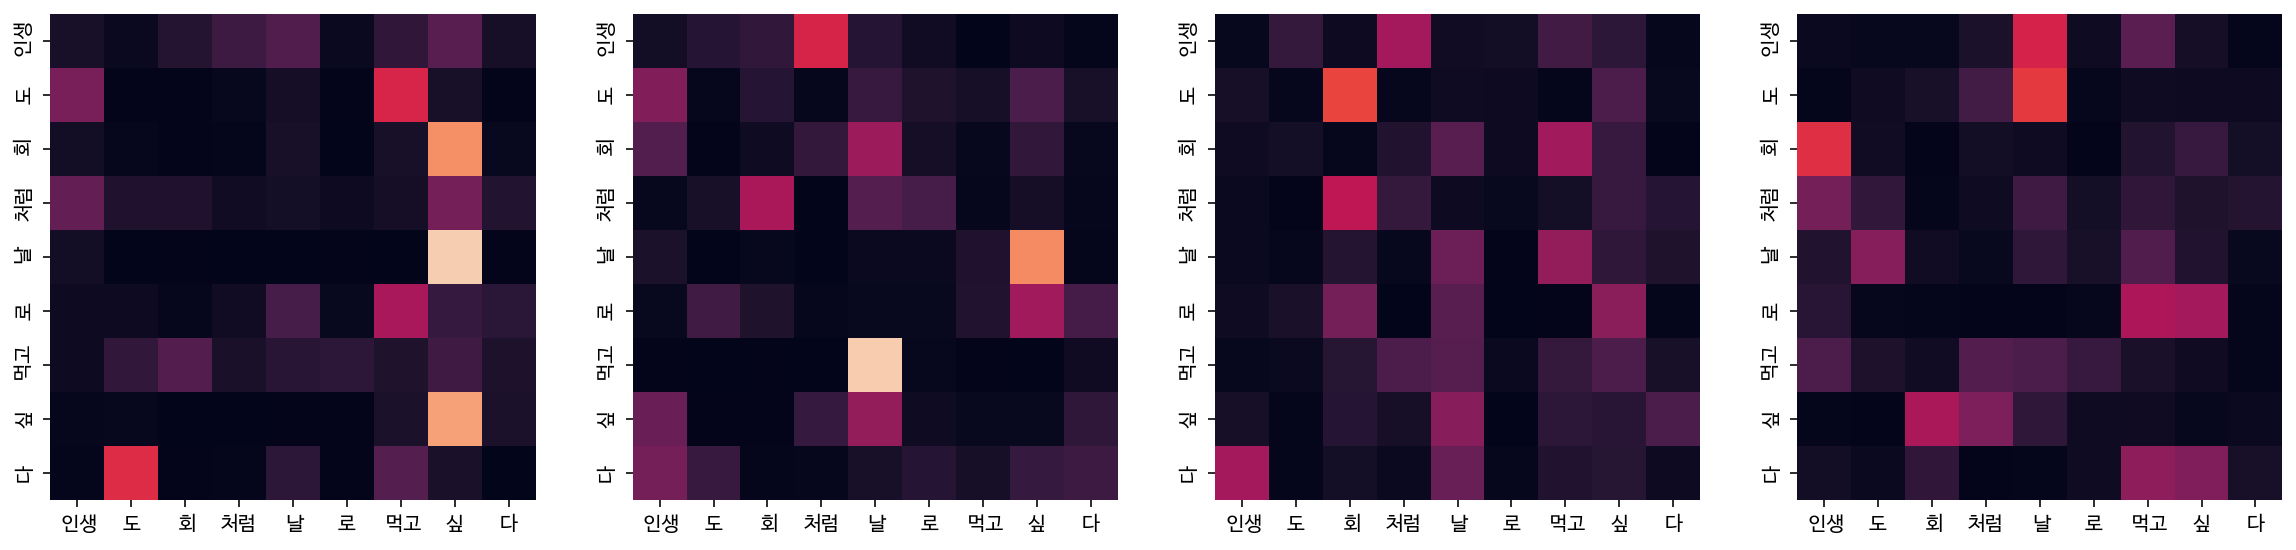

Encoder Layer 2


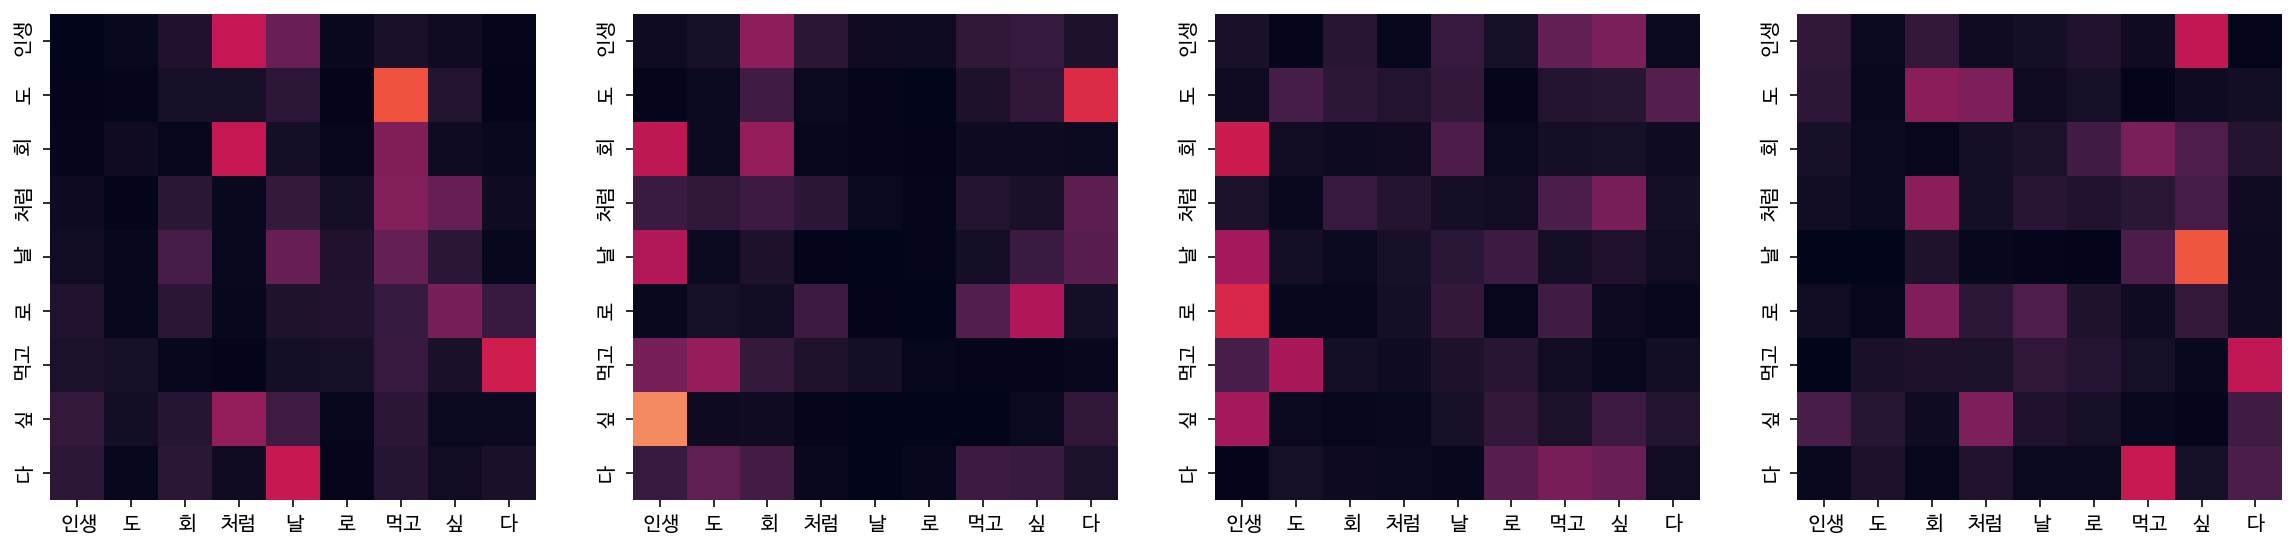

Decoder Self Layer 1


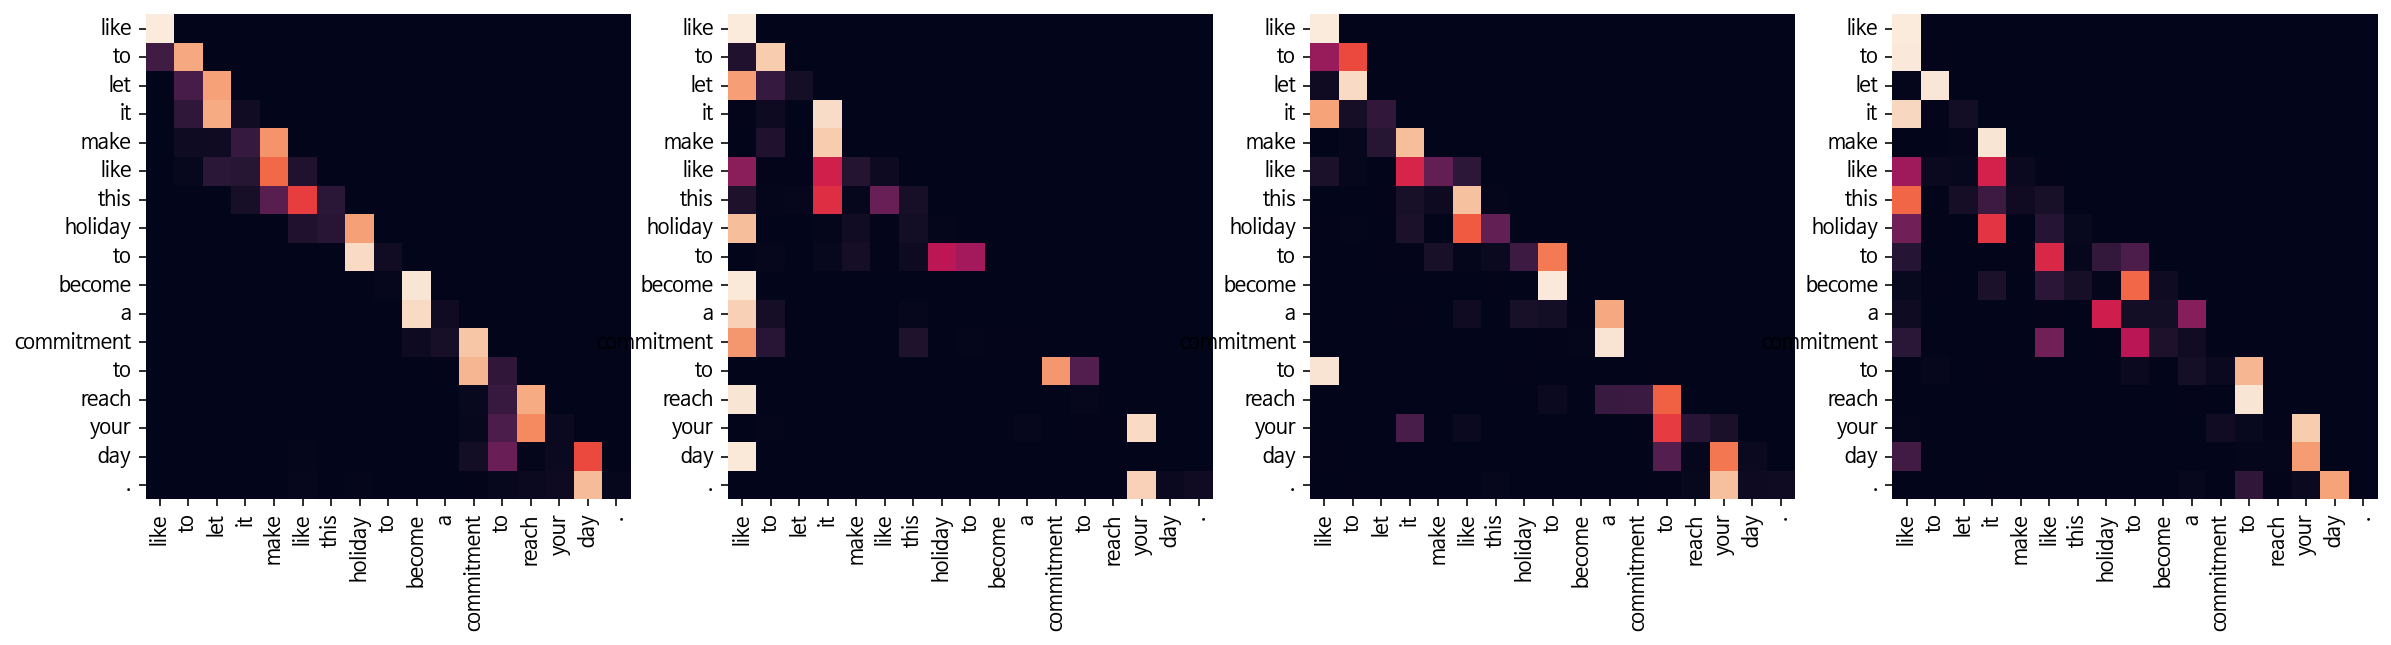

Decoder Src Layer 1


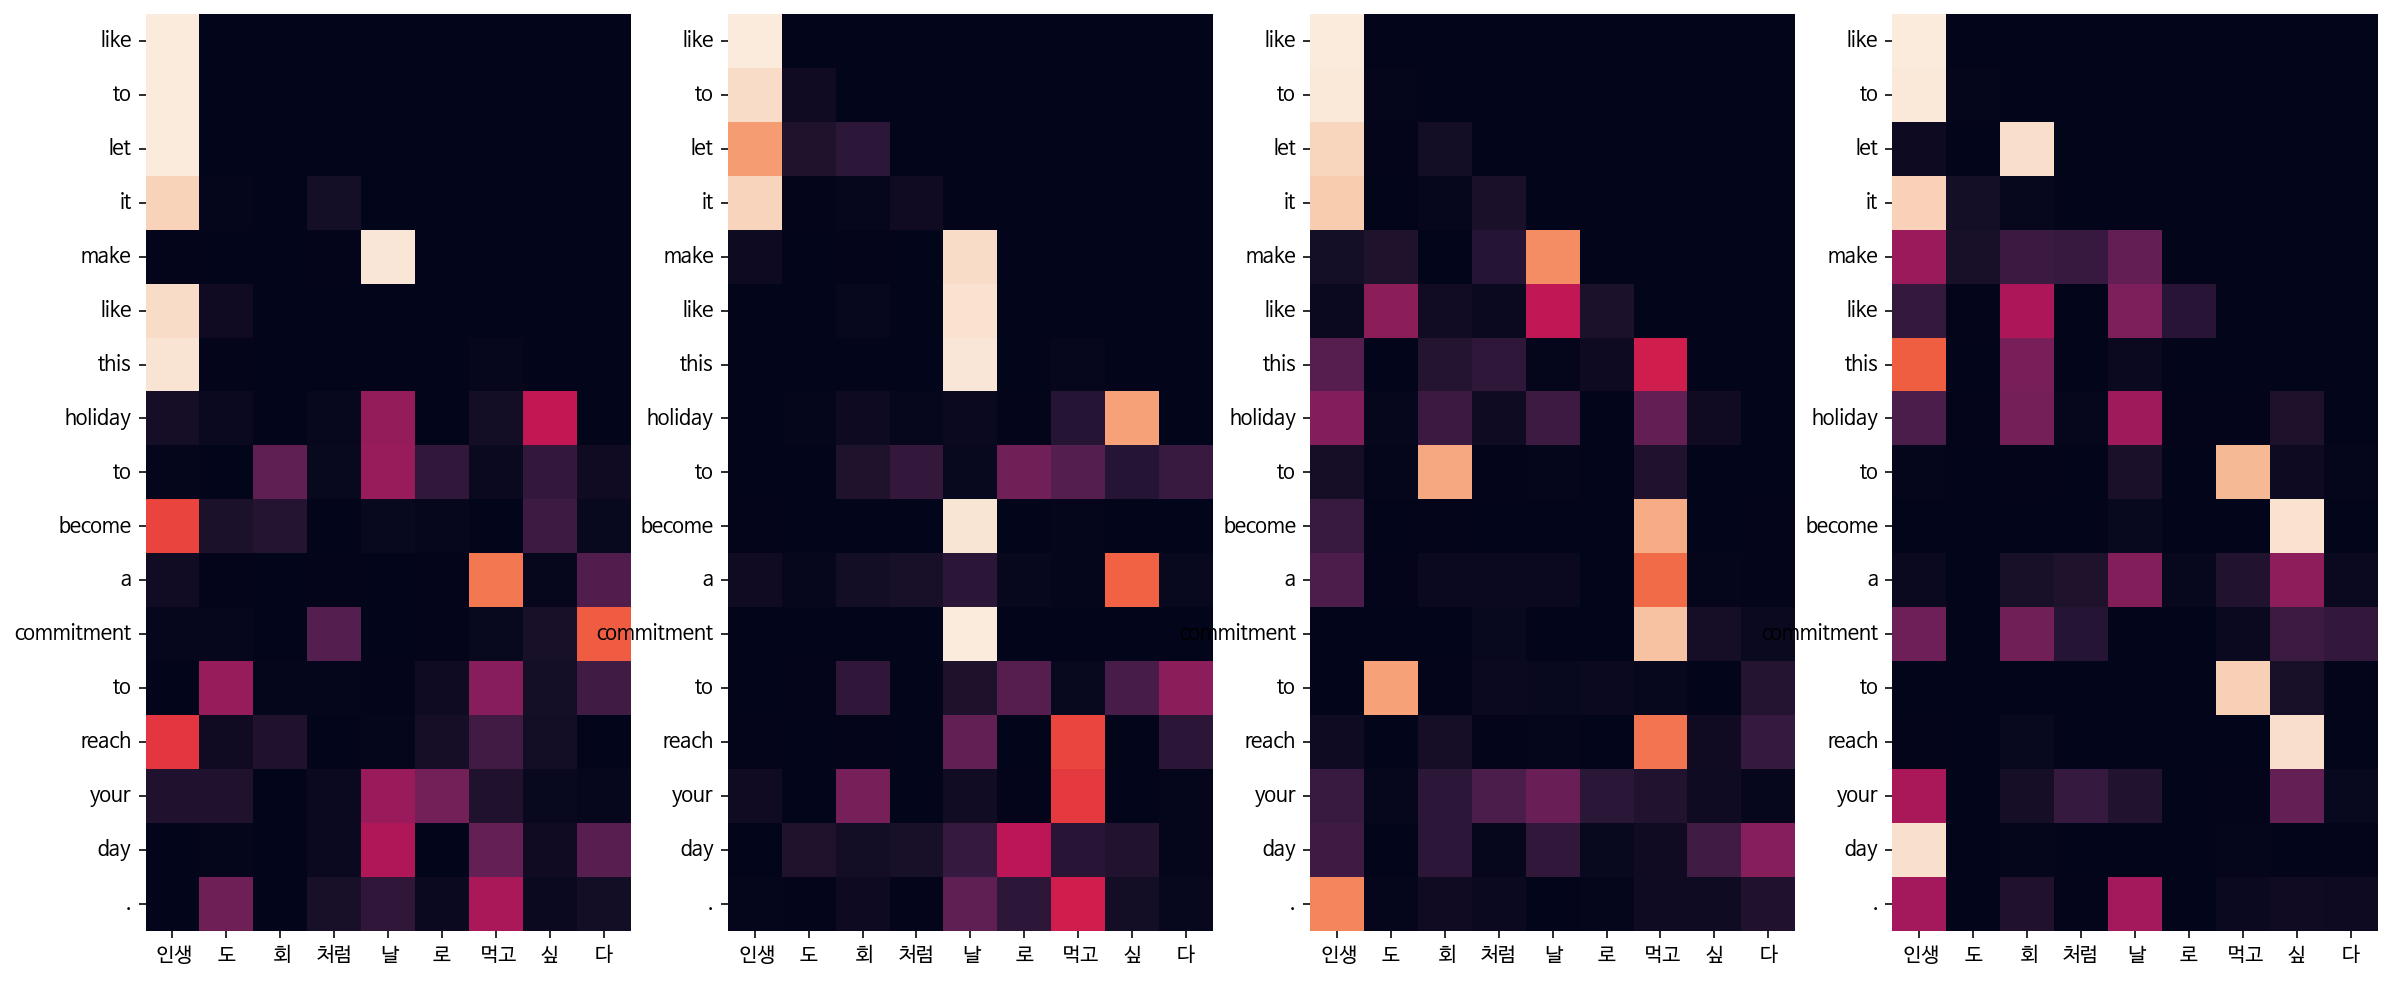

Decoder Self Layer 2


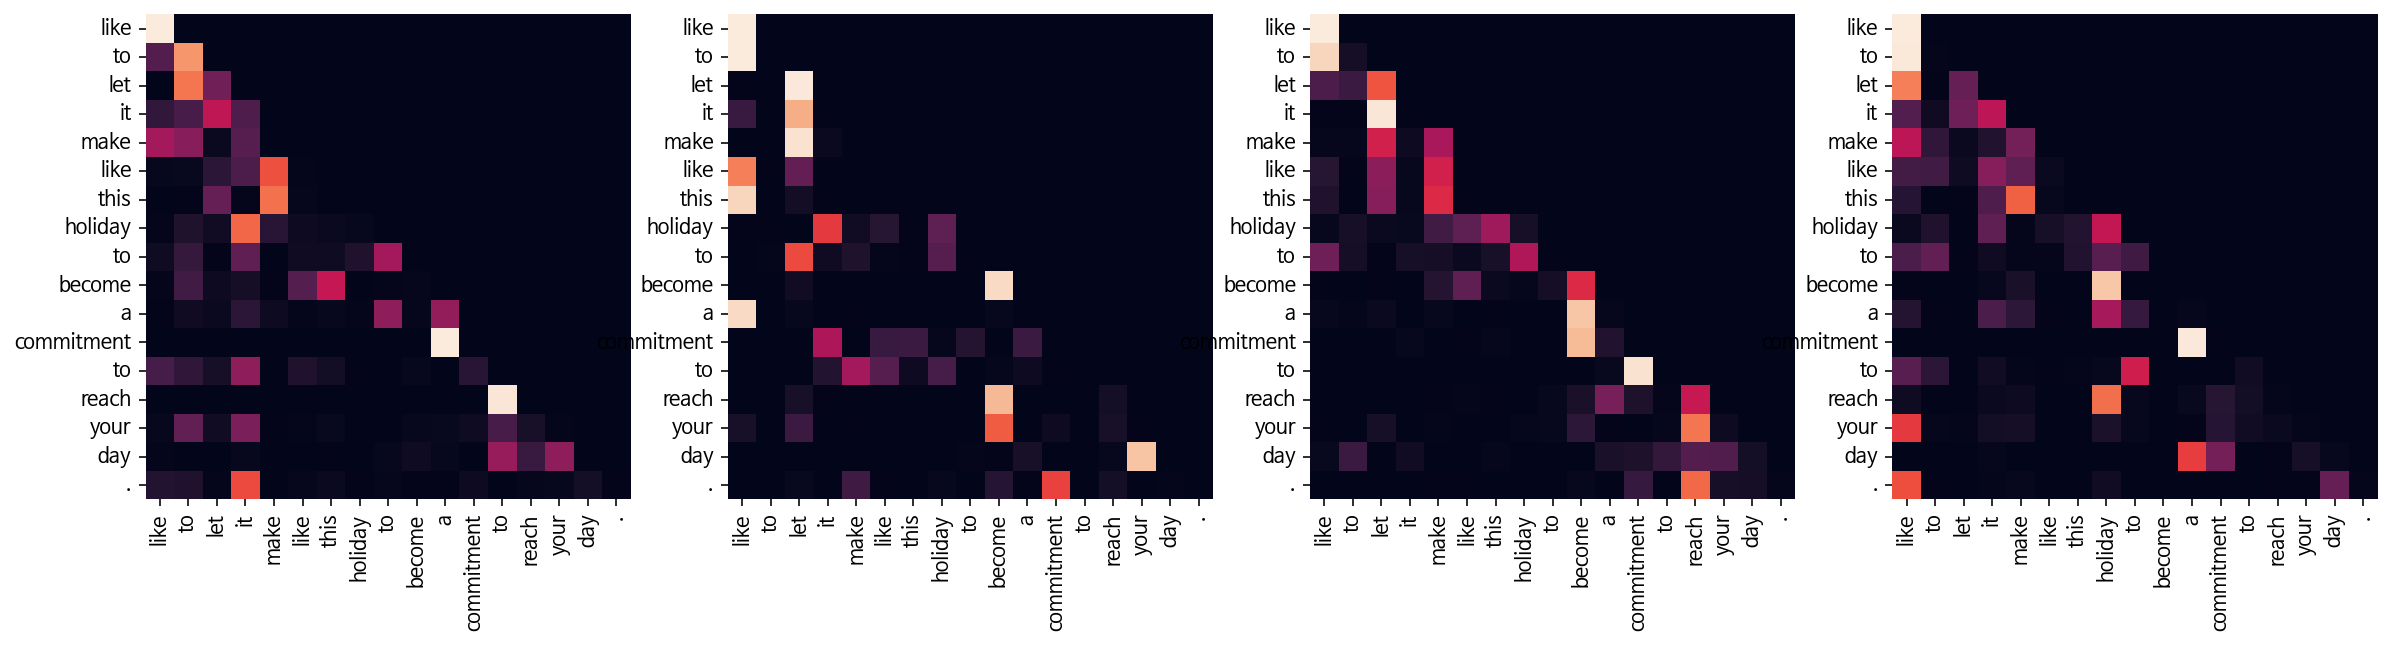

Decoder Src Layer 2


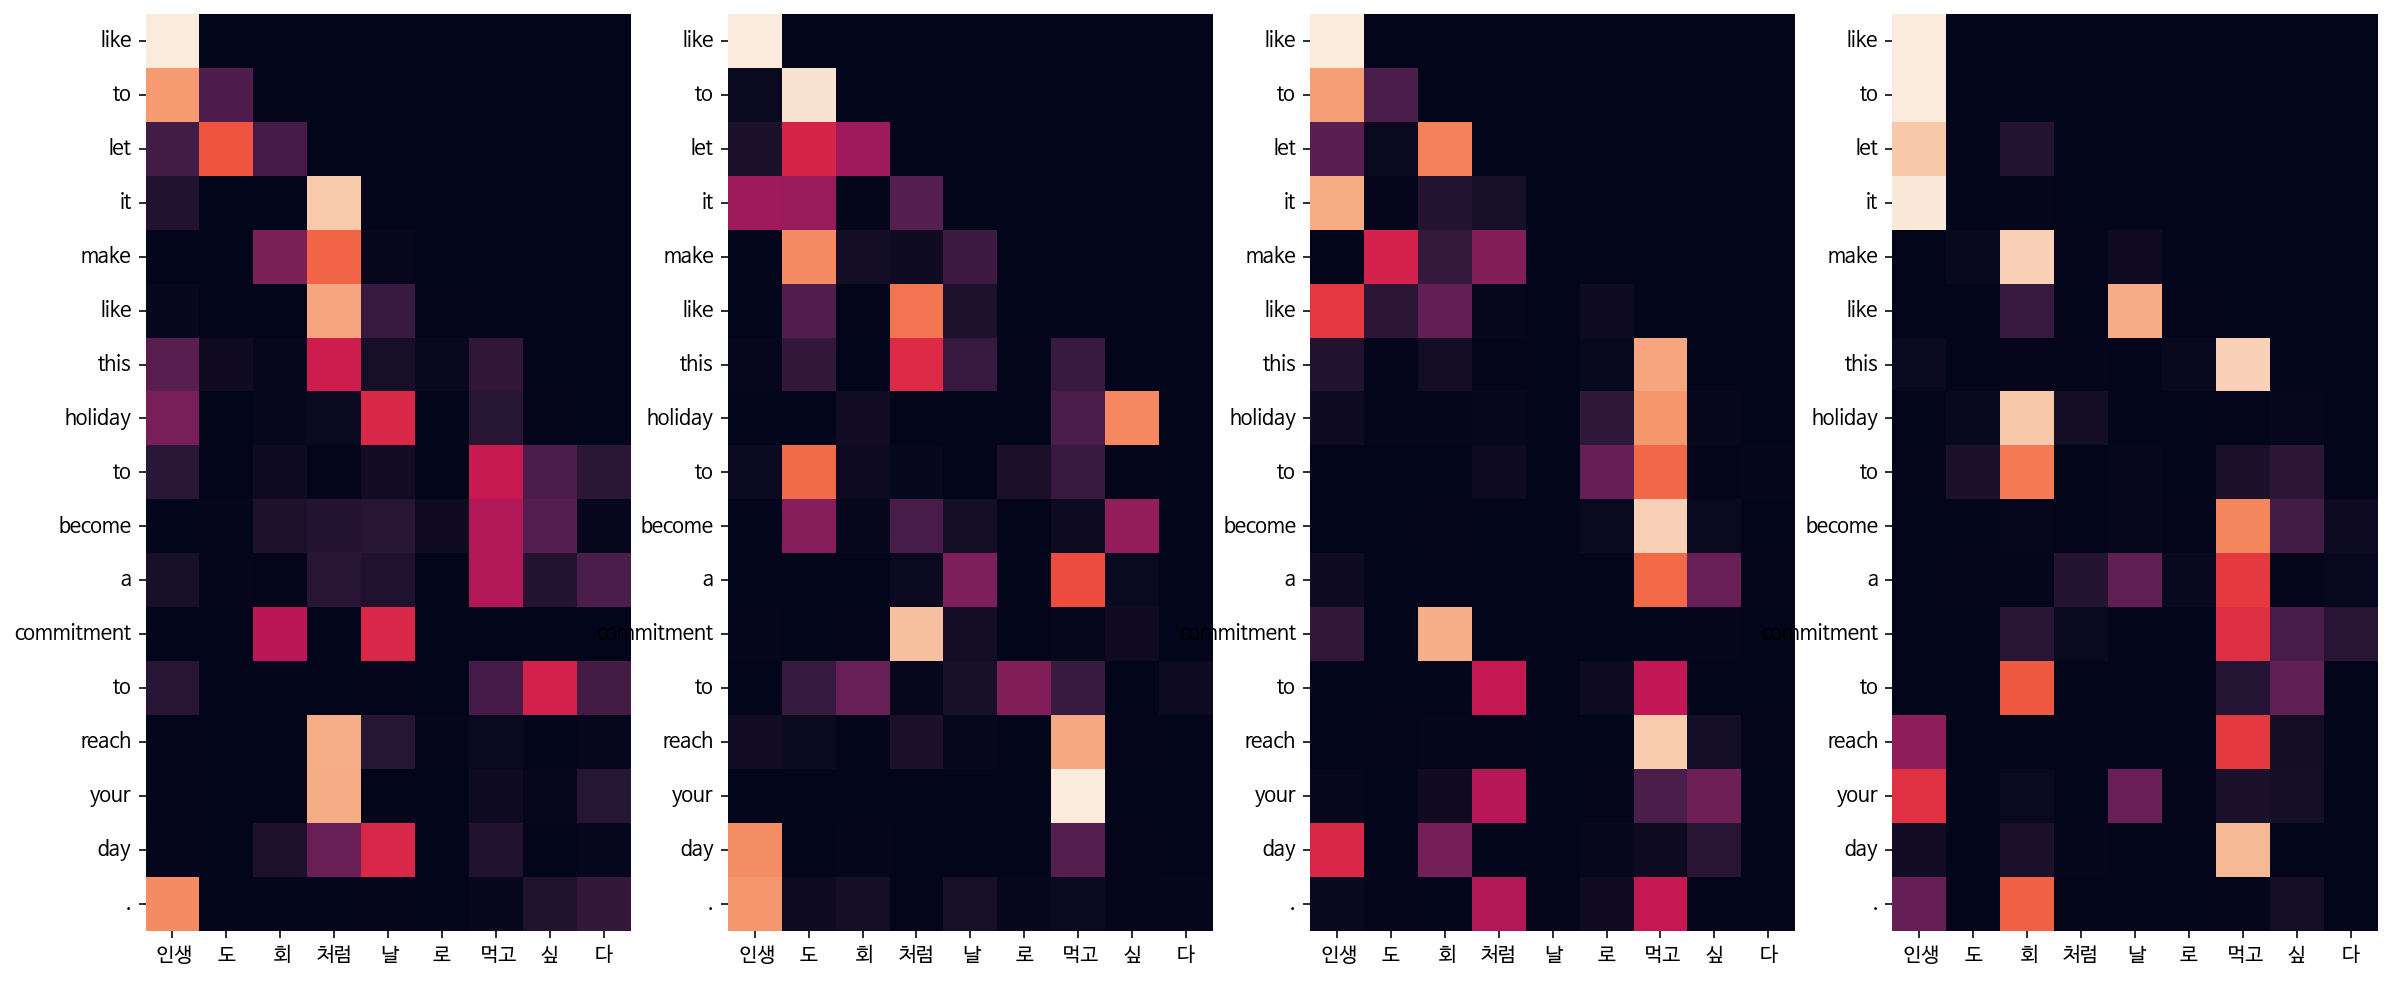

In [35]:
model_try_1.translate('인생도 회처럼 날로 먹고싶다', plot_attention=True)

### 시도 2. 

#### n_layer=4, d_model=512, n_heads=8, d_ff=2048, pos_len=200, dropout=0.2, shared=True, batch_size=64, epochs=20

In [36]:
model_try_2 = Translator(ko_tokenizer, en_tokenizer, n_layers=4, d_model=512, batch_size=64, epochs=20)
model_try_2.train(enc_train, dec_train)

  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the storm is the first time .
Input: 커피는 필요 없다.
Predicted translation: it is not to do this morning .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the people were killed in the capital .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is located .
Input: 커피는 필요 없다.
Predicted translation: it does not give any option .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday s death toll was killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first african president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the citizens of the city .
Input: 커피는 필요 없다.
Predicted translation: it does not have any work .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the seven days .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: residents in the city of san fernando valley .
Input: 커피는 필요 없다.
Predicted translation: no one need to be a little or no longer .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on wednesday a fourth day of the country s civil war .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the protesters displayed the city s mountain .
Input: 커피는 필요 없다.
Predicted translation: nobody needs to do .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were dead and were wounded .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city often is complex in mountain towns .
Input: 커피는 필요 없다.
Predicted translation: no one has taken a man .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in the seven days of the dead .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: people in cities of st .
Input: 커피는 필요 없다.
Predicted translation: the coffee needs to get another step .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in monday s rioting .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the kind of .
Input: 시민들은 도시 속에 산다.
Predicted translation: people in downtown seoul are celebrated in the next few days .
Input: 커피는 필요 없다.
Predicted translation: i need any more badly mutilation .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed with seven people .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the top issue .
Input: 시민들은 도시 속에 산다.
Predicted translation: they gained access to the mountain in the mountain .
Input: 커피는 필요 없다.
Predicted translation: i do need to get an coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven were wounded .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the democratic presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: in reaction to the mountain god know .
Input: 커피는 필요 없다.
Predicted translation: i don t take much of the coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the seventh day of nation s rankings on wednesday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the democratic presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: snakes stake in mountain lions .
Input: 커피는 필요 없다.
Predicted translation: need coffee no need to get these people .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in wednesday s .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they want to have sheltered in mountain and shelterys in the mountain .
Input: 커피는 필요 없다.
Predicted translation: i don t take much coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed with police .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: they helped in mineworkers .
Input: 커피는 필요 없다.
Predicted translation: i don t have any coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed with seven striking machines .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: about spectators in downtown but the mountain
Input: 커피는 필요 없다.
Predicted translation: the coffee doesn t have a here in coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in wednesday s ambush .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is in office .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens write down .
Input: 커피는 필요 없다.
Predicted translation: need to be easy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people seven died .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the kind of leader .
Input: 시민들은 도시 속에 산다.
Predicted translation: they took up in the mountain .
Input: 커피는 필요 없다.
Predicted translation: needards .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the kind of .
Input: 시민들은 도시 속에 산다.
Predicted translation: they had a secretive mountain .
Input: 커피는 필요 없다.
Predicted translation: need coffee needs a coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died seven people the official said .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in stayed in the mountain .
Input: 커피는 필요 없다.
Predicted translation: i don t think coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed with seven people .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the top spot .
Input: 시민들은 도시 속에 산다.
Predicted translation: gain access to other trees .
Input: 커피는 필요 없다.
Predicted translation: it needs to get there .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed with seven others .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the kind of leader .
Input: 시민들은 도시 속에 산다.
Predicted translation: locals have often been public in the city .
Input: 커피는 필요 없다.
Predicted translation: the coffee needs to take precautions .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were wounded .


Input: 인생도 회처럼 날로 먹고싶다
Predicted translation: like to do it means to declaration it .
Encoder Layer 1


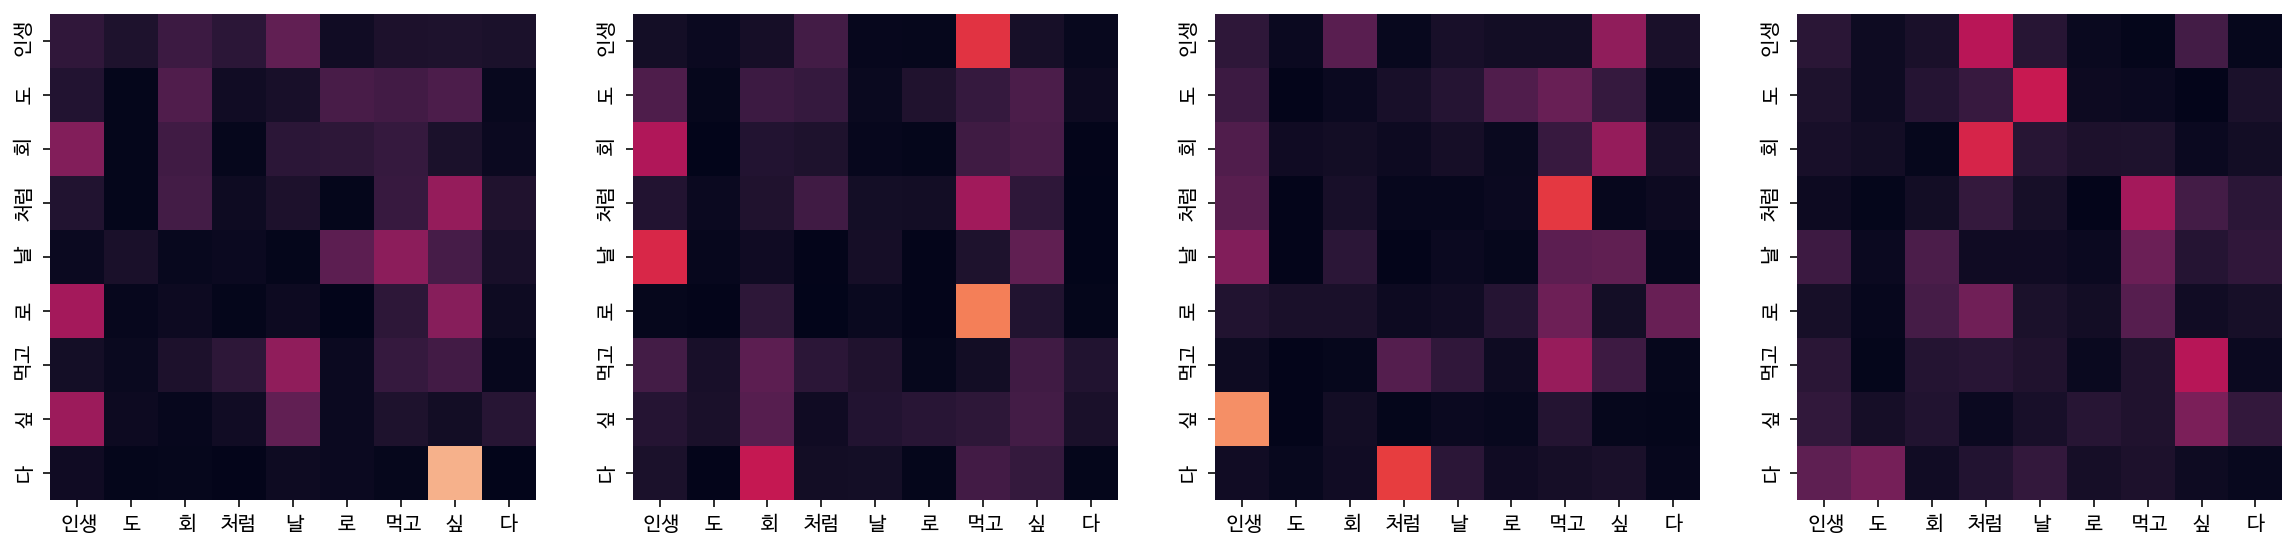

Encoder Layer 2


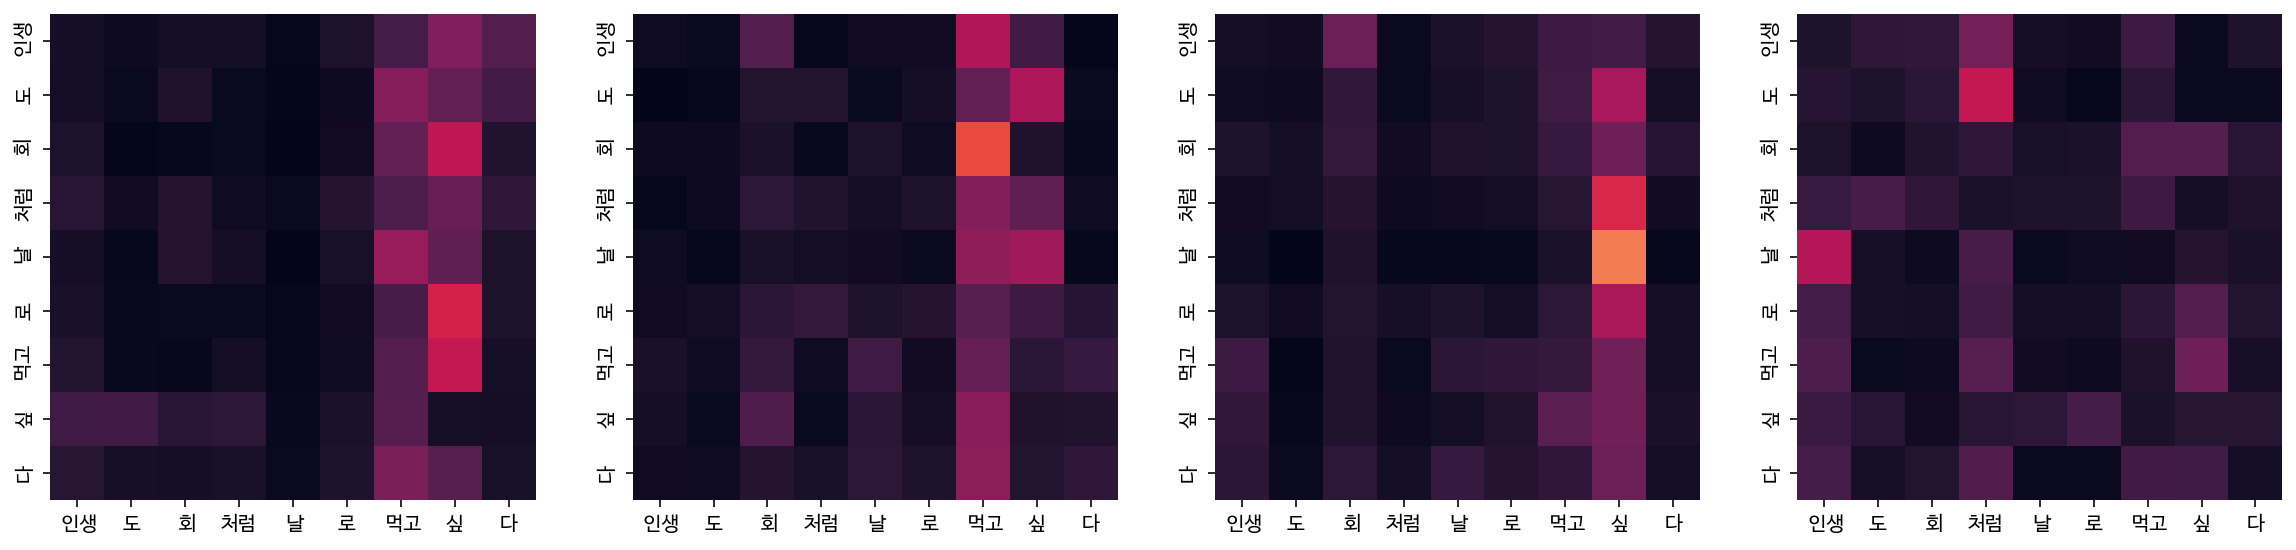

Decoder Self Layer 1


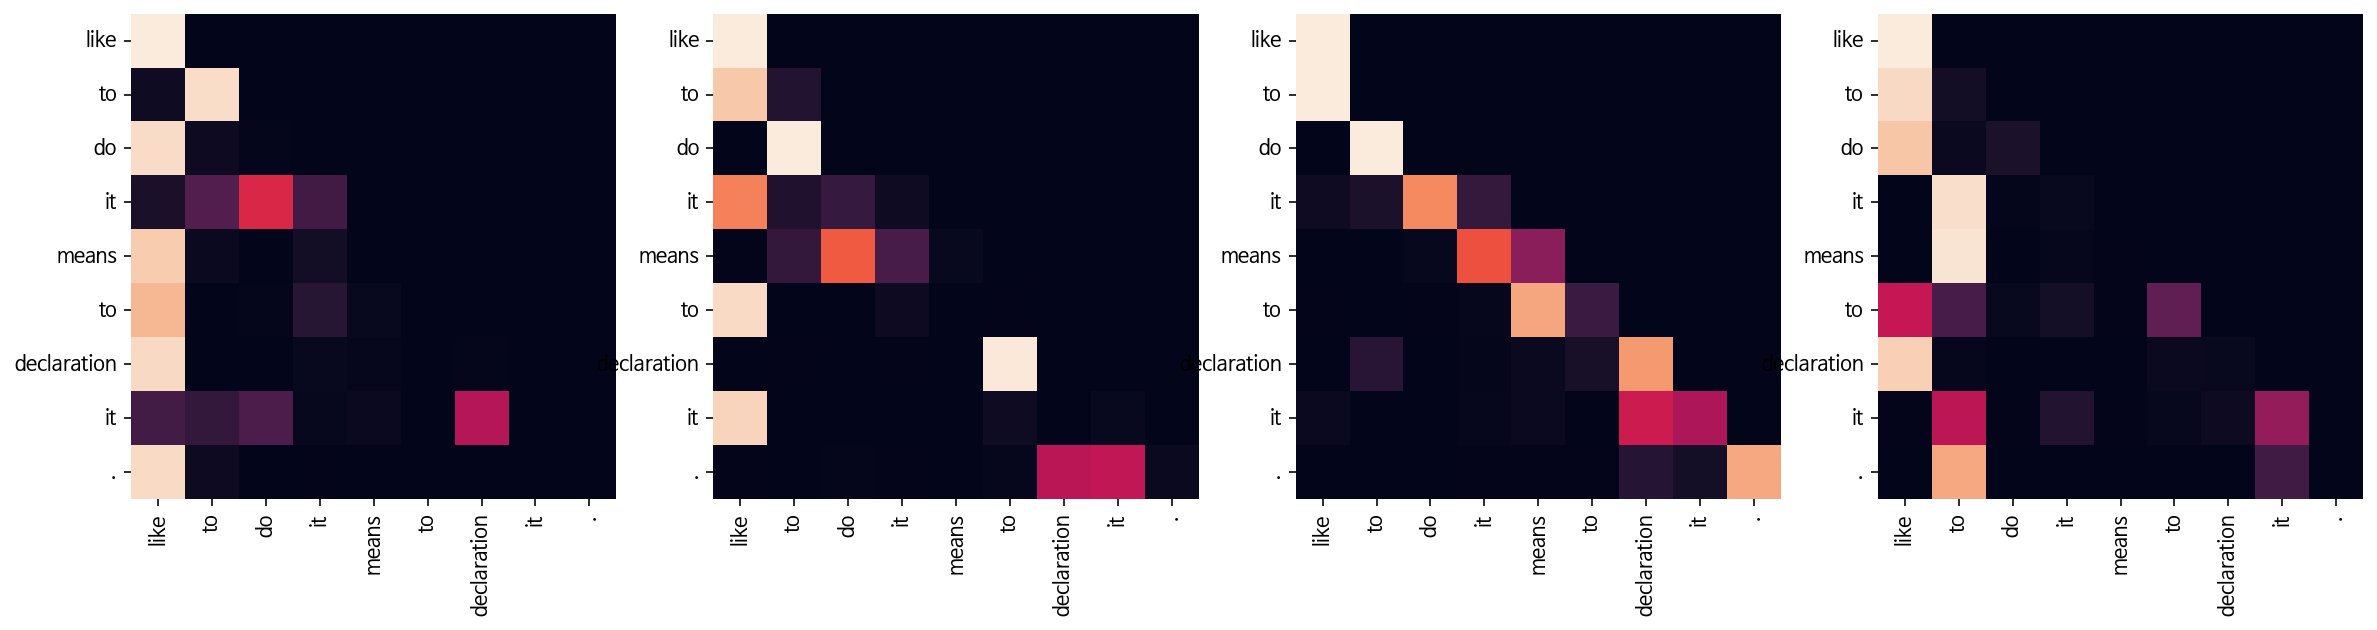

Decoder Src Layer 1


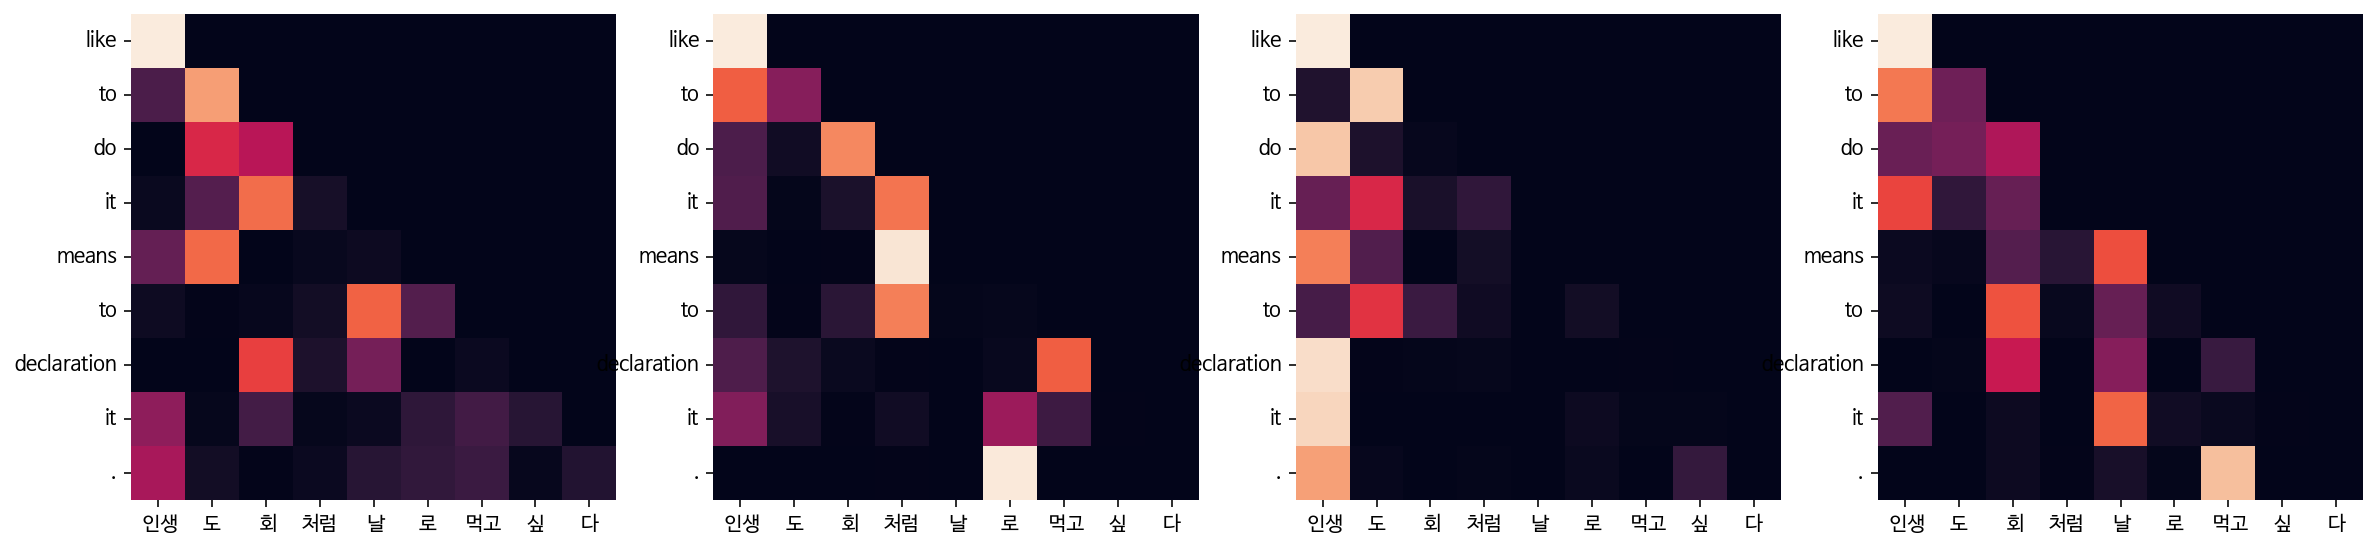

Decoder Self Layer 2


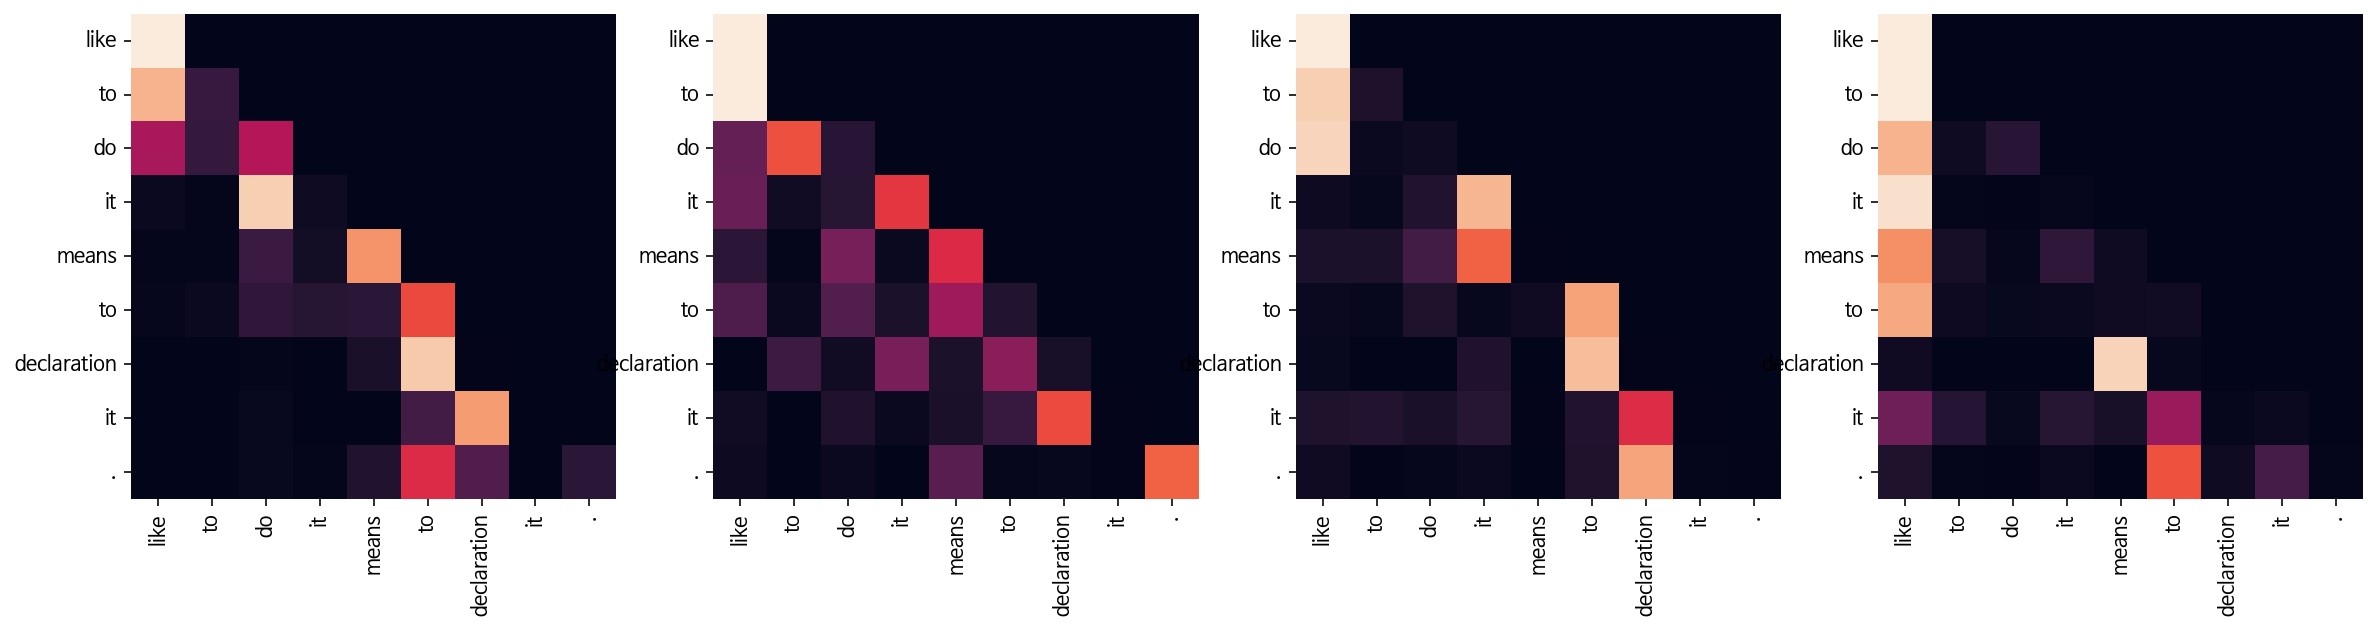

Decoder Src Layer 2


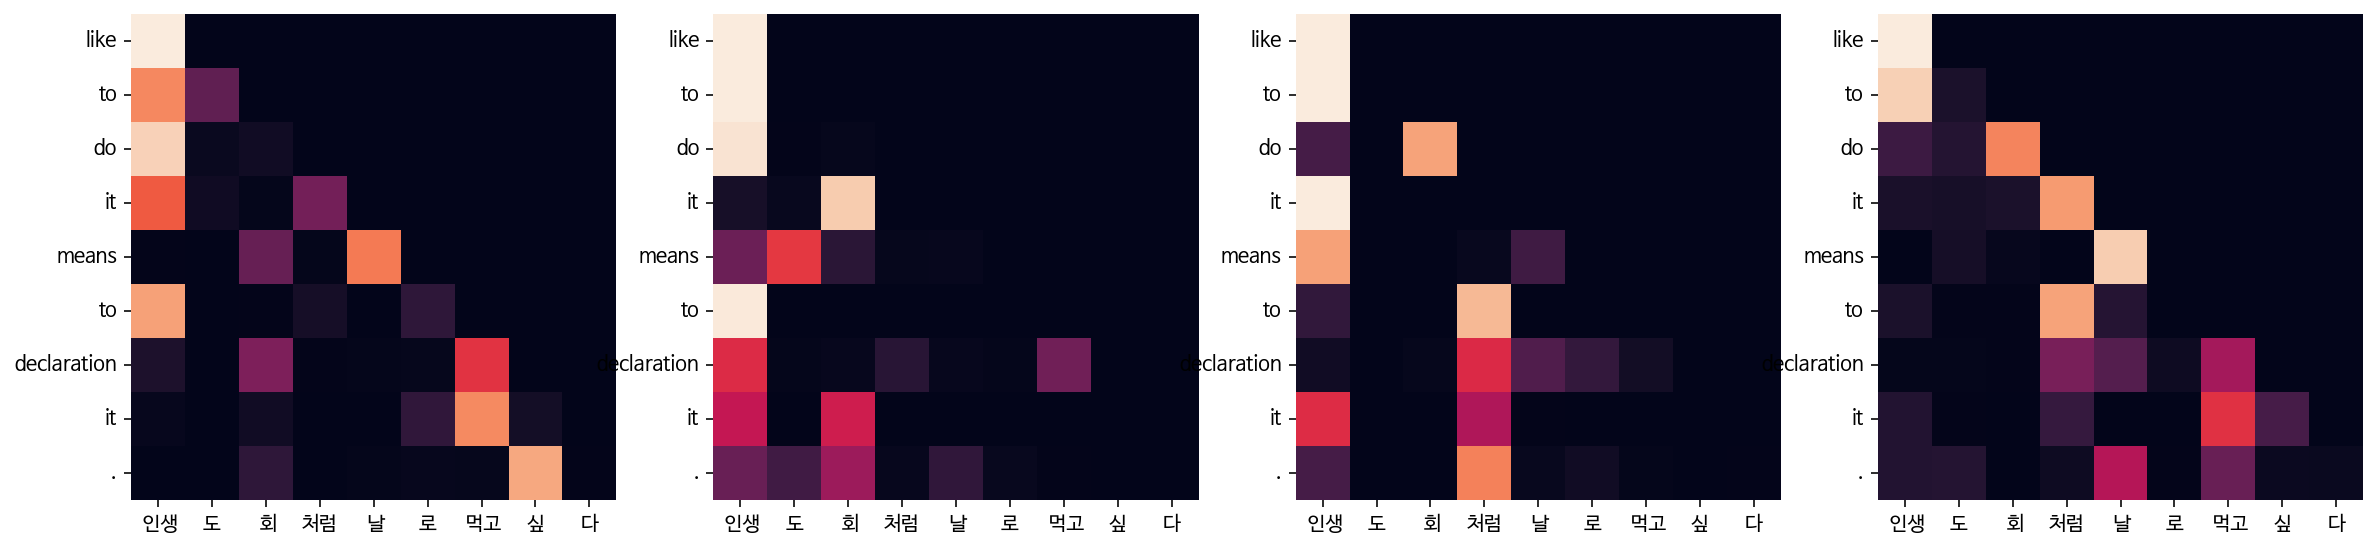

In [37]:
model_try_2.translate('인생도 회처럼 날로 먹고싶다', plot_attention=True)

### 시도 3. 

#### n_layer=6, d_model=512, n_heads=8, d_ff=2048, pos_len=200, dropout=0.2, shared=True, batch_size=64, epochs=20

In [30]:
model_try_3 = Translator(ko_tokenizer, en_tokenizer, n_layers=6, d_model=512, batch_size=64, epochs=20)
model_try_3.train(enc_train, dec_train)

  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama has been a candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: the first time the first time .
Input: 커피는 필요 없다.
Predicted translation: it s not to be very good .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the city struck a four people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the obama is a black man .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of the city of the city of the city .
Input: 커피는 필요 없다.
Predicted translation: the coffee is not to be .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a year old .
Input: 시민들은 도시 속에 산다.
Predicted translation: the streets of the city s main city .
Input: 커피는 필요 없다.
Predicted translation: we don t need to be a big screen .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the main opposition grand national party gnp was killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the nominee for the presidential election .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a city of the city .
Input: 커피는 필요 없다.
Predicted translation: it s a coffee card .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deaths were reported .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is ready for his departure .
Input: 시민들은 도시 속에 산다.
Predicted translation: just one city is a city of cities .
Input: 커피는 필요 없다.
Predicted translation: if you don t coffeeally coffeeally .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death occurred wednesday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are cities .
Input: 커피는 필요 없다.
Predicted translation: it needs to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead included were among the dead monday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president elect obama s campaign for president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in cities and city .
Input: 커피는 필요 없다.
Predicted translation: need to be necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the fatalities were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is in the general election .
Input: 시민들은 도시 속에 산다.
Predicted translation: today is the city of new york city .
Input: 커피는 필요 없다.
Predicted translation: he needs to be treated .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven were among the victims tuesday the reported .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is in the republican presidential campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: on earth the city of cities .
Input: 커피는 필요 없다.
Predicted translation: it needs coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were among the dead and another were killed saturday night .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is in the republican presidential campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are crowded in cities .
Input: 커피는 필요 없다.
Predicted translation: the need is not a wasteful should be need to need to be needed to need to be needed to the web site .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were among the dead and seven were on wednesday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president elect barack obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: that s just in from cities .
Input: 커피는 필요 없다.
Predicted translation: he needs to be needing to watch out .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven were fatalities monday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is his top aide to illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: everyone is outside of the city .
Input: 커피는 필요 없다.
Predicted translation: he needs a need to be left home .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were killed and two were wounded sunday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s presidential rivals couldn t be president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are patrolling cities where have helped calmest .
Input: 커피는 필요 없다.
Predicted translation: the only need for coffee was not need ford drink .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven were killed monday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s campaign is over in the presidential election .
Input: 시민들은 도시 속에 산다.
Predicted translation: on the city of jerusalem is another .
Input: 커피는 필요 없다.
Predicted translation: he needs a need to be needed home .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were among the dead and were injured .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s campaign is in the republican presidential campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: just on the other cities of new york city .
Input: 커피는 필요 없다.
Predicted translation: there needs no need to be needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the body of the victims killed seven


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama on the agenda
Input: 시민들은 도시 속에 산다.
Predicted translation: part of the cities in big city .
Input: 커피는 필요 없다.
Predicted translation: the need is not a bold .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven were killed monday night .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the front runner for the presidential nomination .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are worried about another  cities .
Input: 커피는 필요 없다.
Predicted translation: needing coffee needs coffee needs coffee needs needs coffee needs coffee needs coffee needs coffee needs coffee needs need but the need need needs motive need for that needs motive .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was reported in icheon .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is his voice .
Input: 시민들은 도시 속에 산다.
Predicted translation: on the city of mirage in the city is .
Input: 커피는 필요 없다.
Predicted translation: the need is just a fa cup .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the body of the seven deaths on wednesday


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the voice for president .
Input: 시민들은 도시 속에 산다.
Predicted translation: part of the city is me being coese .
Input: 커피는 필요 없다.
Predicted translation: he needs to be left .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven were killed monday night .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama on president
Input: 시민들은 도시 속에 산다.
Predicted translation: on the city it s just shifting to makeshift ice in the city .
Input: 커피는 필요 없다.
Predicted translation: he needed to be needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven were deaths the ministry of foreign affairs and trade announced tuesday evening .


Input: 인생도 회처럼 날로 먹고싶다
Predicted translation: like the songs thing to do like car .
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


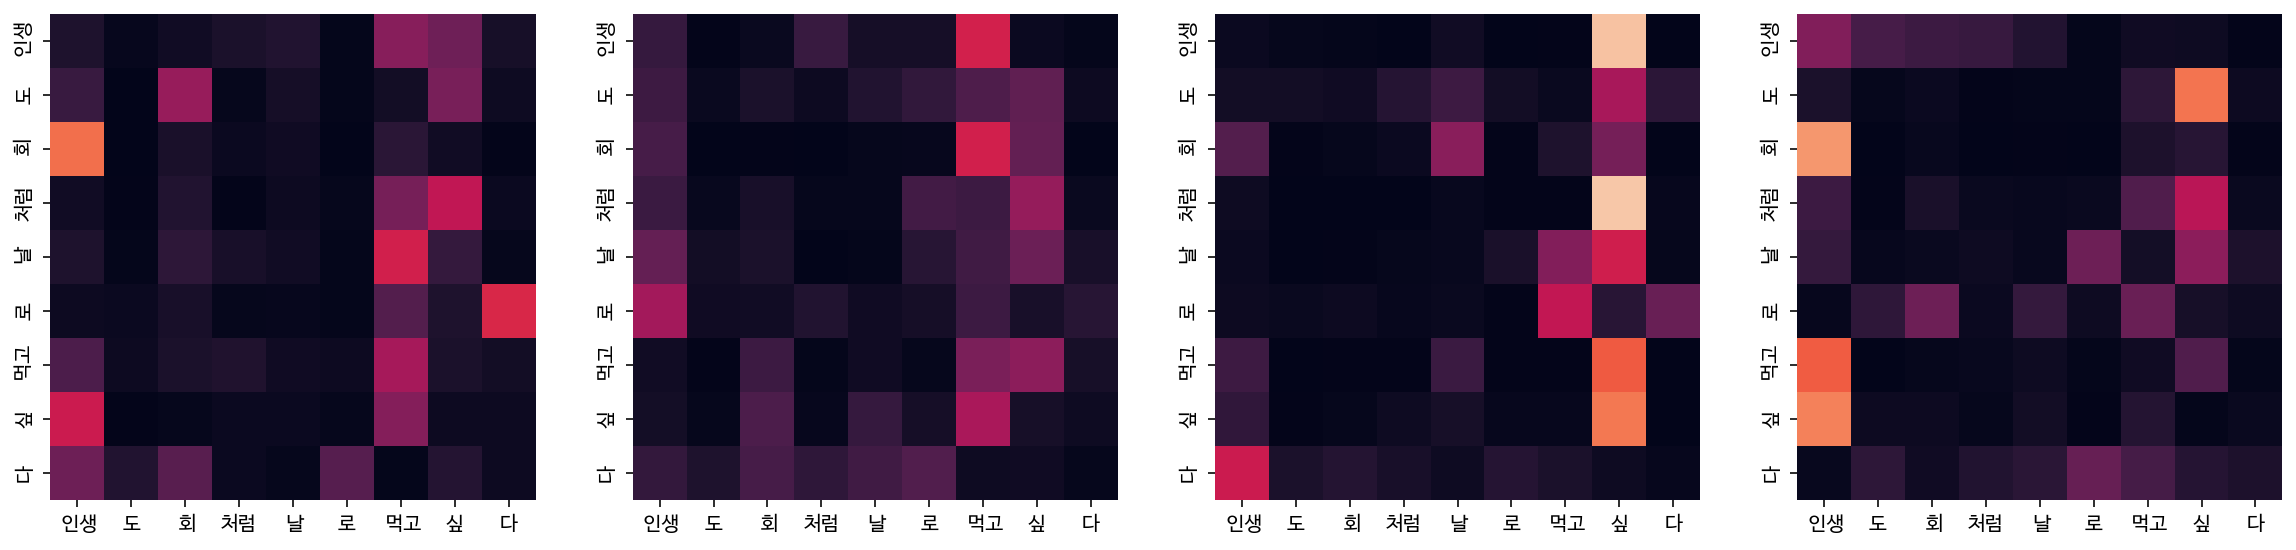

Encoder Layer 2


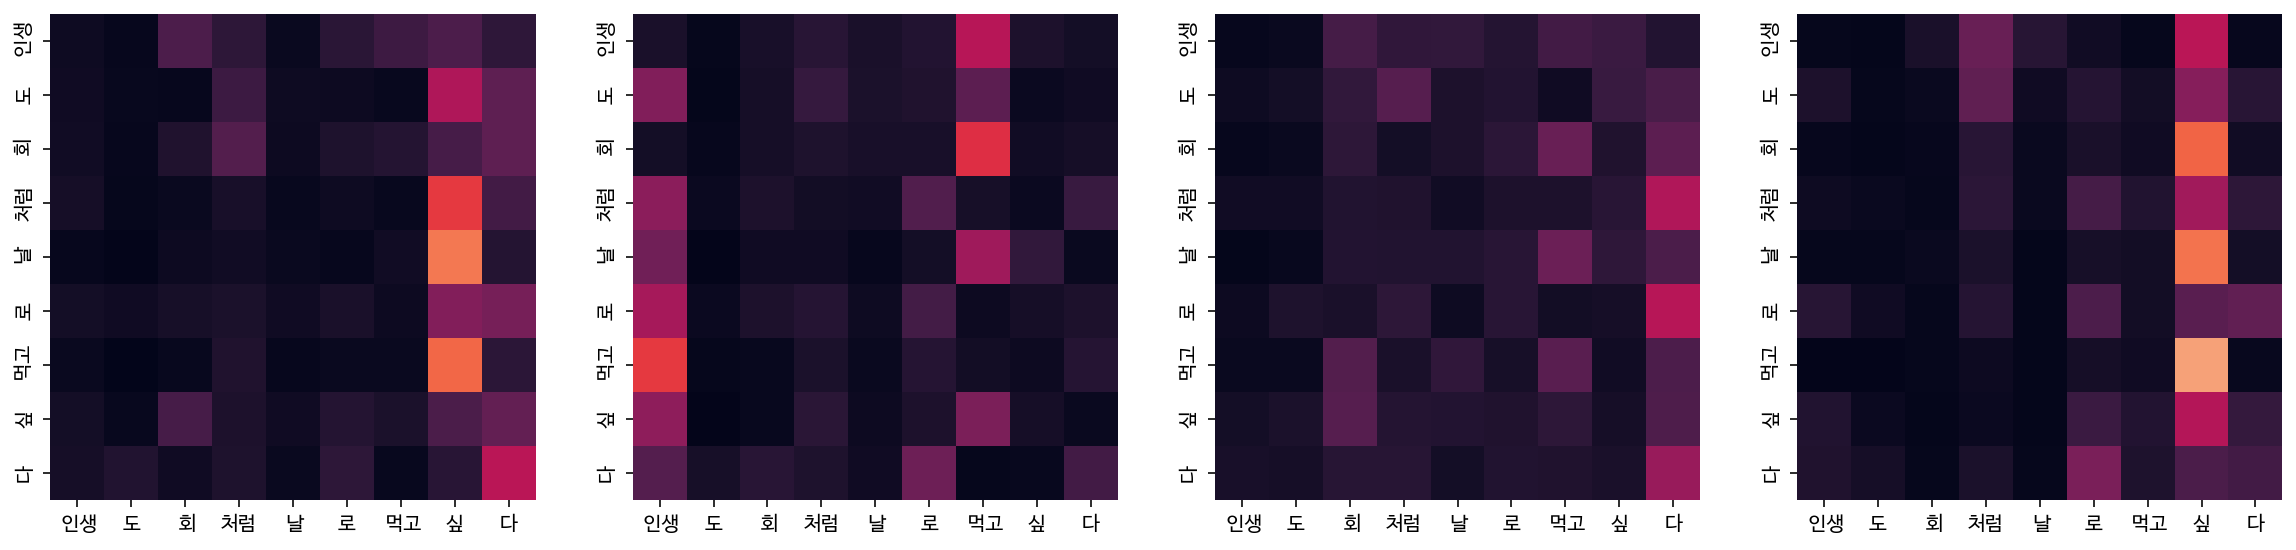

Decoder Self Layer 1


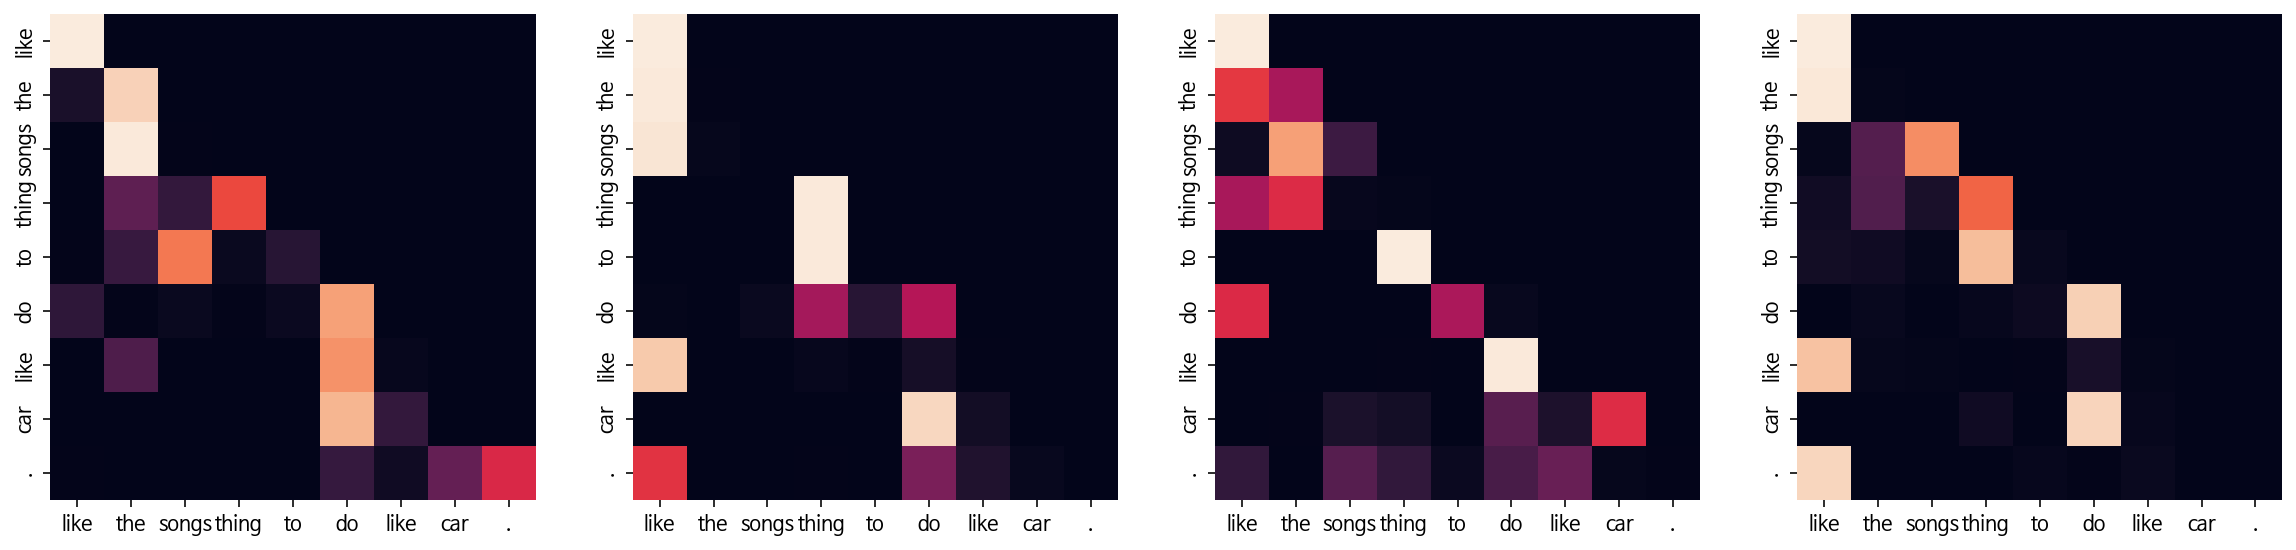

Decoder Src Layer 1


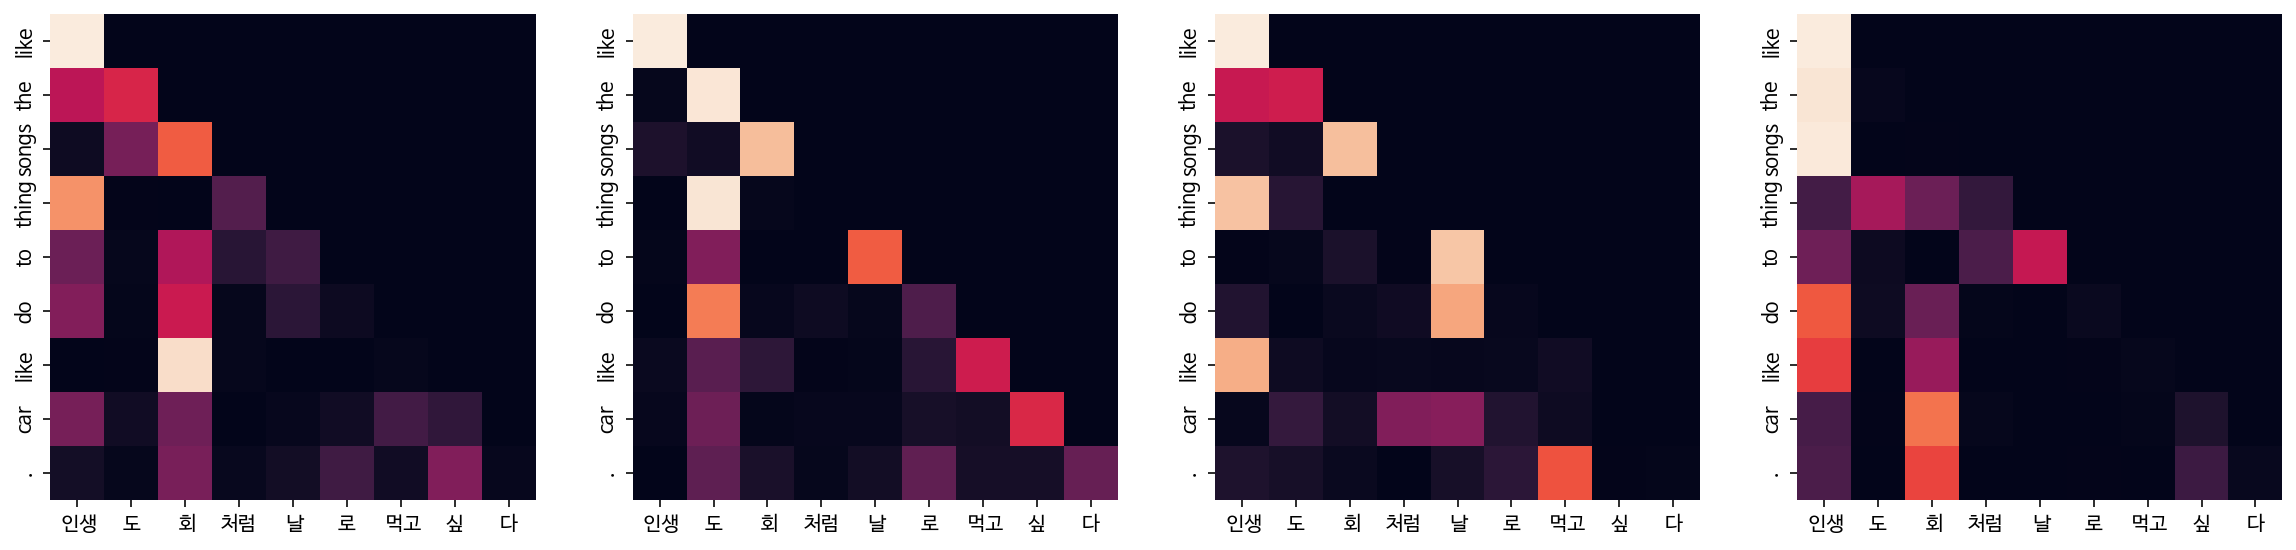

Decoder Self Layer 2


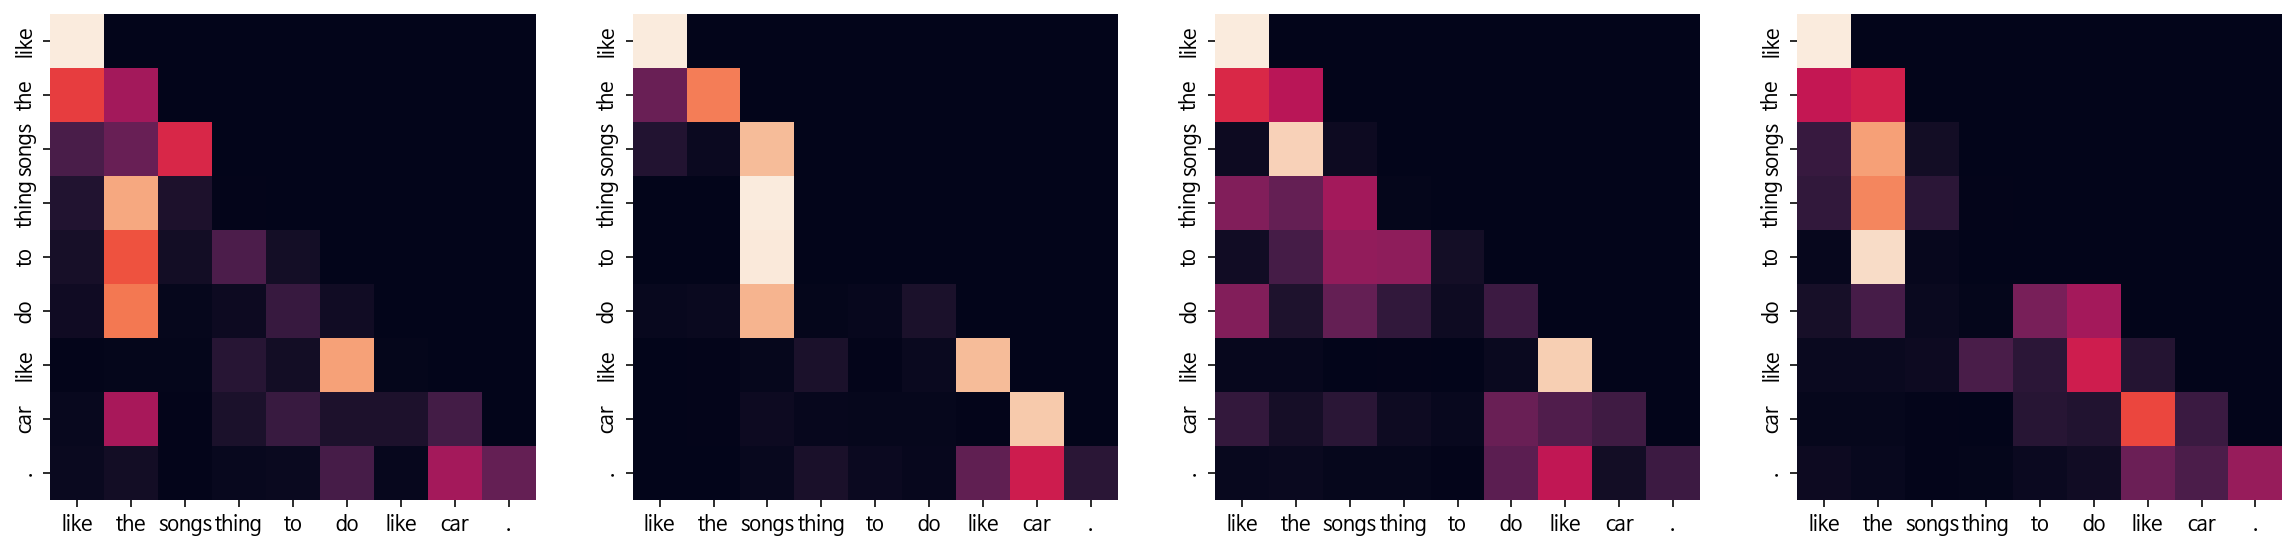

Decoder Src Layer 2


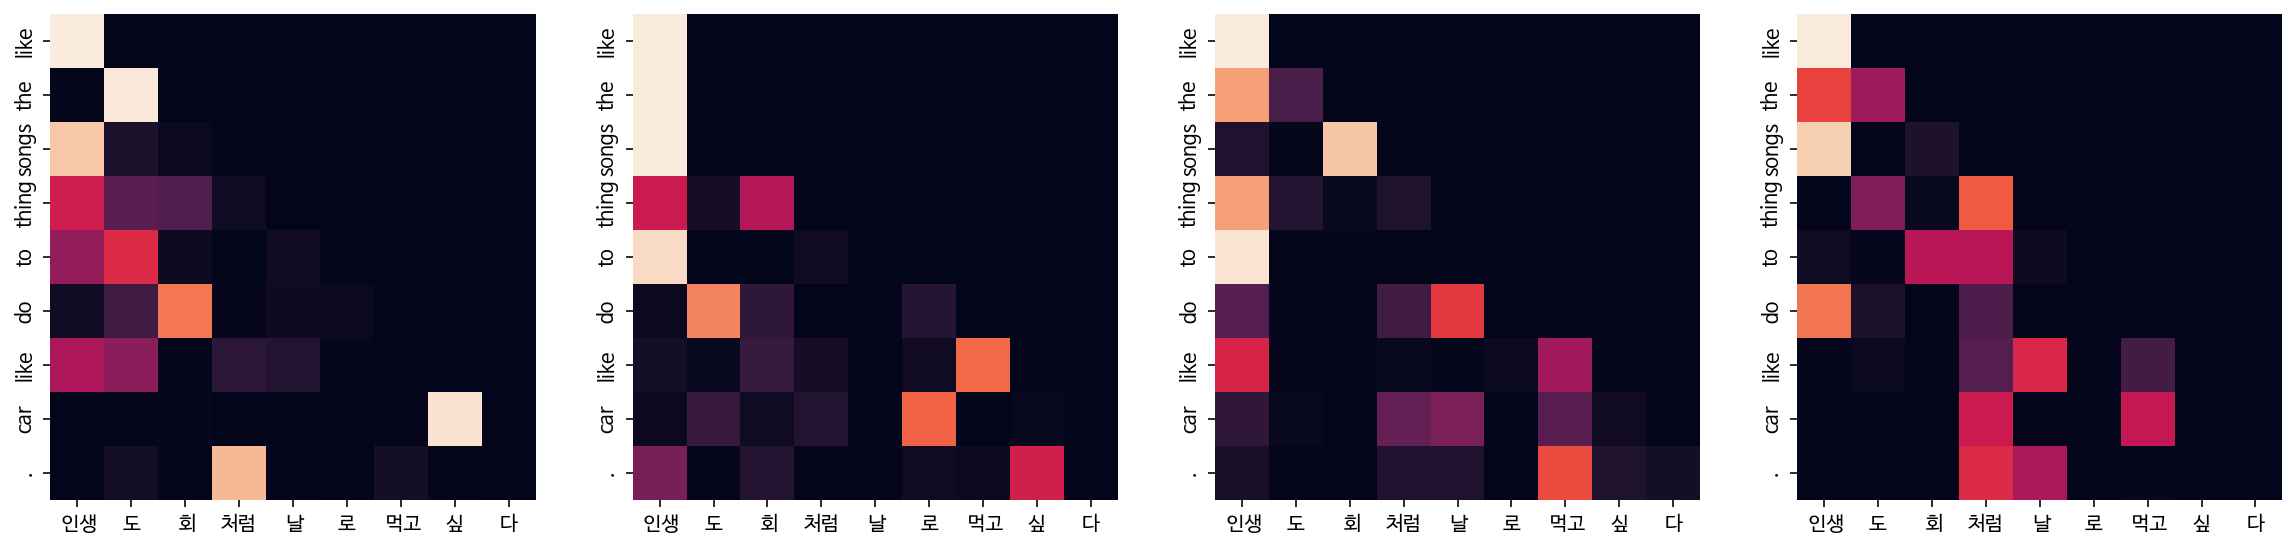

In [31]:
model_try_3.translate('인생도 회처럼 날로 먹고싶다', plot_attention=True)

### 시도 4. 

#### n_layer=8, d_model=512, n_heads=8, d_ff=2048, pos_len=200, dropout=0.2, shared=True, batch_size=64, epochs=20

In [32]:
model_try_4 = Translator(ko_tokenizer, en_tokenizer, n_layers=8, d_model=512, batch_size=64, epochs=20)
model_try_4.train(enc_train, dec_train)

  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is expected to be a campaign of the president of the president s campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: the couple is also found in the city of the city of the city of the city of the city of the city of the city of the city of the city of the city of the city of the city of the city .
Input: 커피는 필요 없다.
Predicted translation: there is a little very much of the first time .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on wednesday injured in the quake of the quake was killed on wednesday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first to becoming president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city was a city of the city .
Input: 커피는 필요 없다.
Predicted translation: there are no need to be no one .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday the deadly death toll was dead .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president s lead to illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: the town of the city is the city of .
Input: 커피는 필요 없다.
Predicted translation: nobody may be very much less than a few days .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death of .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the town s urban area is not a big welcome .
Input: 커피는 필요 없다.
Predicted translation: the coffee needs to be carried out .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead was dead and more than people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the citizens are part of the city .
Input: 커피는 필요 없다.
Predicted translation: coffee needs to need any coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday a man was killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the nation s presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the peak in the city .
Input: 커피는 필요 없다.
Predicted translation: there needs more need to calm .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the latest clashes .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the cities are inlight .
Input: 커피는 필요 없다.
Predicted translation: no needs to make a fight .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died on thursday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: climb to the cities of the skies .
Input: 커피는 필요 없다.
Predicted translation: no need for therapeutic purposes
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the question was pushed between the mountain .
Input: 커피는 필요 없다.
Predicted translation: no needs for coffee or needs to keep the need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday seven people were killed the ministry said .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: people turn stop in this city .
Input: 커피는 필요 없다.
Predicted translation: but needs to take a pounds .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven were killed on monday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the cities of the cities of the city .
Input: 커피는 필요 없다.
Predicted translation: no need to do anything .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is s vice president .
Input: 시민들은 도시 속에 산다.
Predicted translation: in a new car sold the mountain city of se fi .
Input: 커피는 필요 없다.
Predicted translation: need to get more than coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seventh of the death toll was plus men .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: in a new year s family name was mobed in ways to return to the cities of escalating plymouth in the cities nearby city of melbourne .
Input: 커피는 필요 없다.
Predicted translation: need to need need to need need need to need need need to wrong .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on thursday of the deadly wounded .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is s presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: question was a self assistance american .
Input: 커피는 필요 없다.
Predicted translation: but need for a need for action .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seventh of the death toll was on sunday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: some people took to the mountain in the city .
Input: 커피는 필요 없다.
Predicted translation: the need for coffee is needed for anyway to couples who need a pre recent italy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on thursday a man was killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president s presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: questioners take care in coast .
Input: 커피는 필요 없다.
Predicted translation: no need part of what is needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven were killed sunday iraqi special press reported .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: caracas .
Input: 커피는 필요 없다.
Predicted translation: the need for card .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on thursday the seven dead were reported .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is to be president .
Input: 시민들은 도시 속에 산다.
Predicted translation: in turn black cities police found the blood .
Input: 커피는 필요 없다.
Predicted translation: the needs to keep the blame .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seventh person died thursday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: caracas jack las vegas was lined up for the th time .
Input: 커피는 필요 없다.
Predicted translation: no one should do it again
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday of the killed seven people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: proud town dresss a san antonio .
Input: 커피는 필요 없다.
Predicted translation: no need for a coffee or drop in coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday of the dead killed seven people .


Input: 인생도 회처럼 날로 먹고싶다
Predicted translation: sometimes eating almost stalled you should like a cit like a cit of your hand
Encoder Layer 1


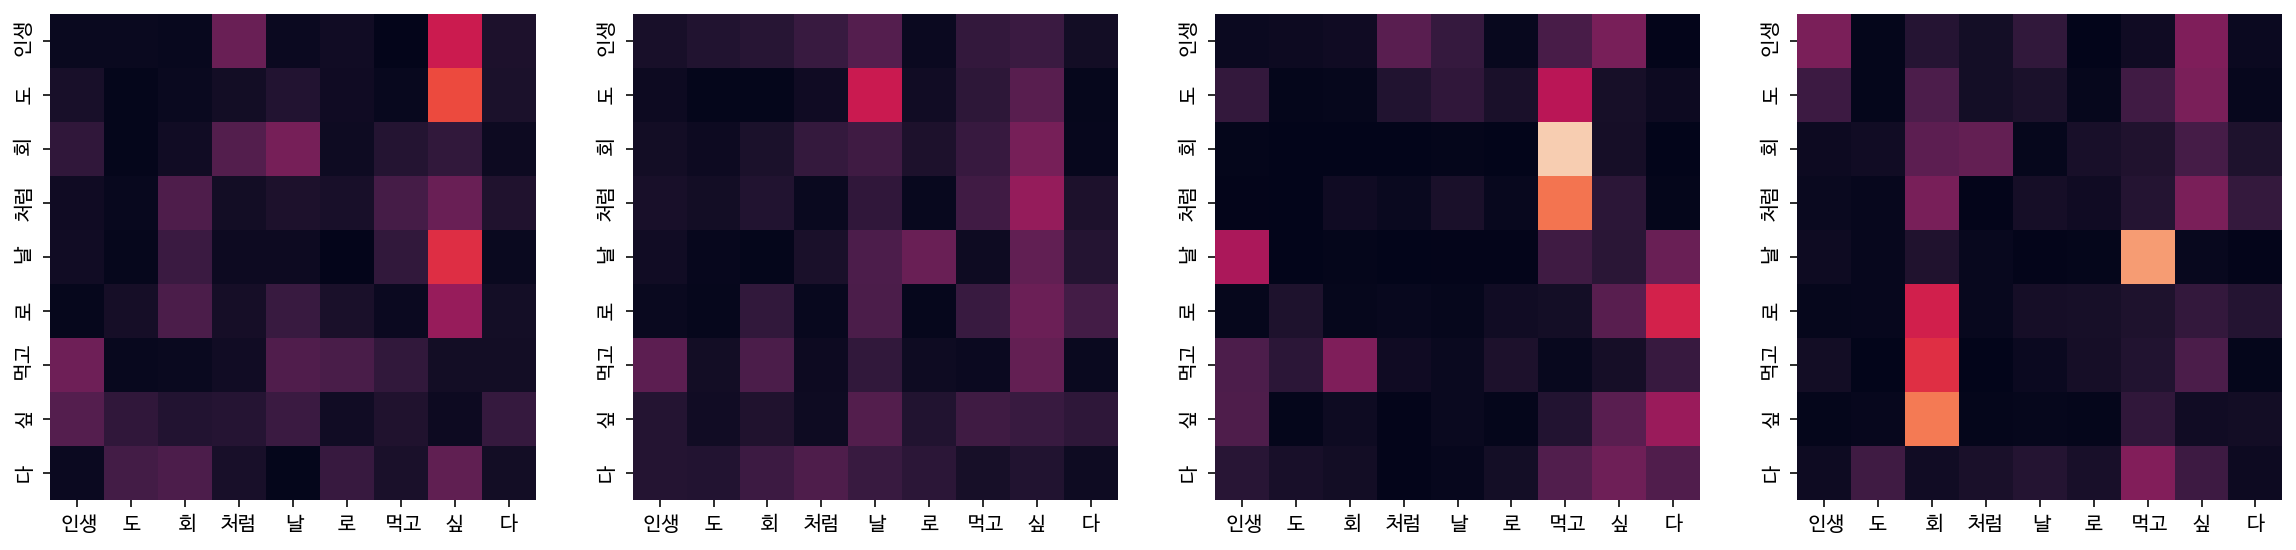

Encoder Layer 2


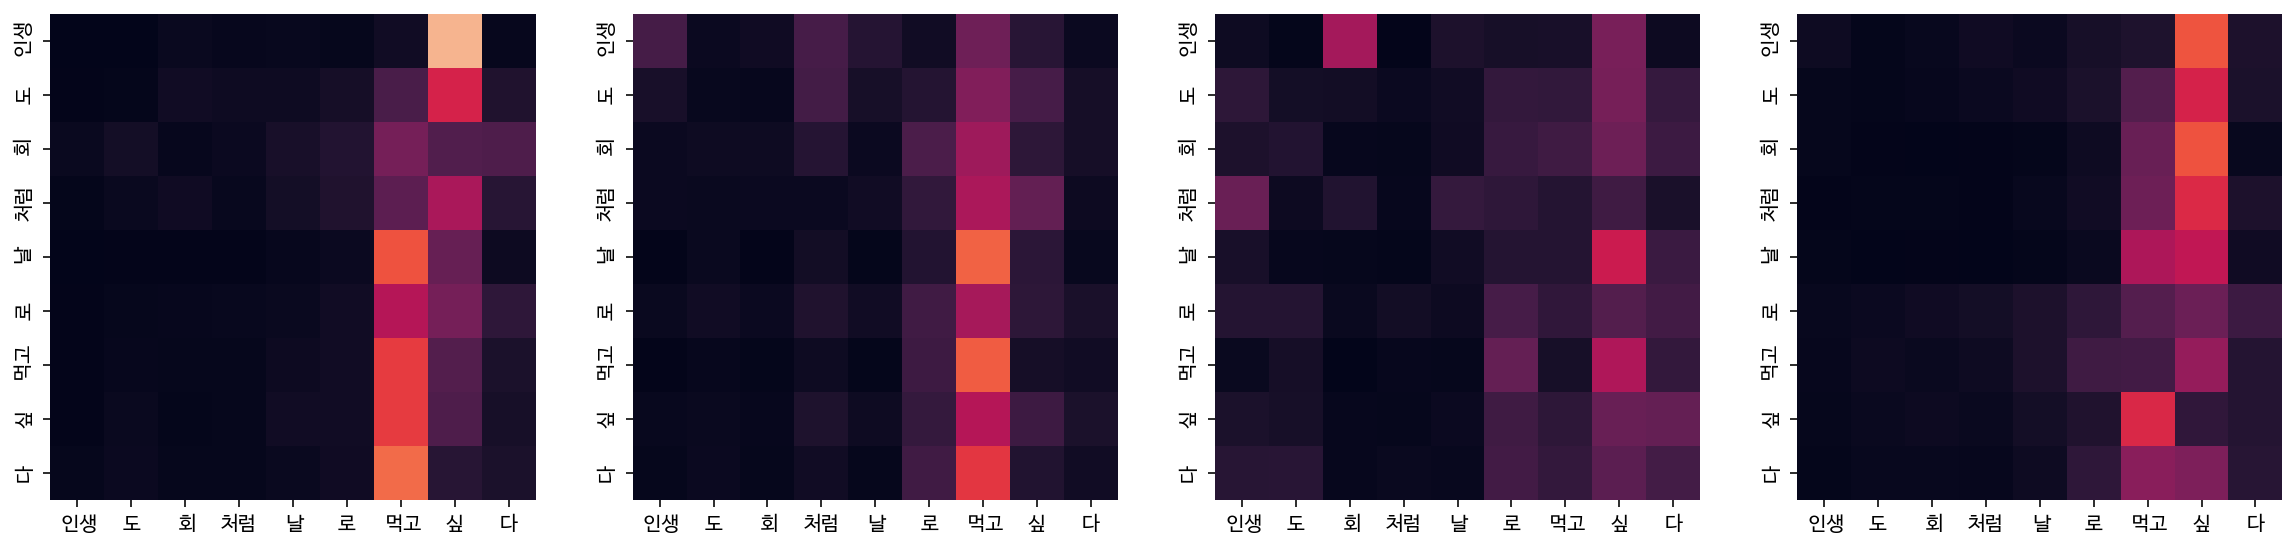

Decoder Self Layer 1


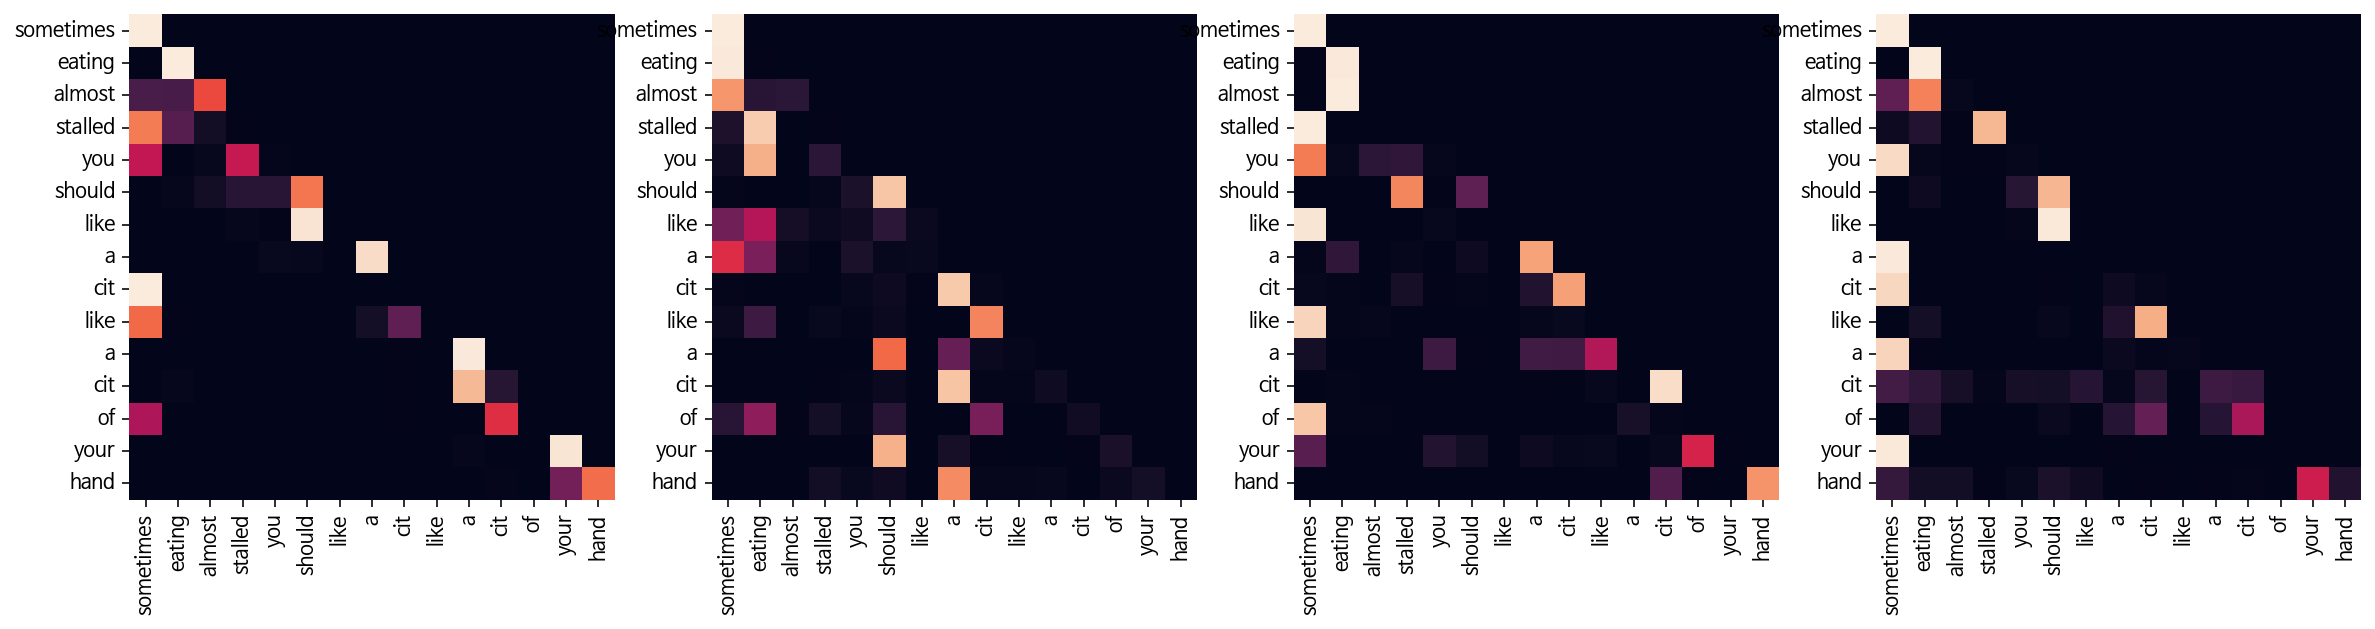

Decoder Src Layer 1


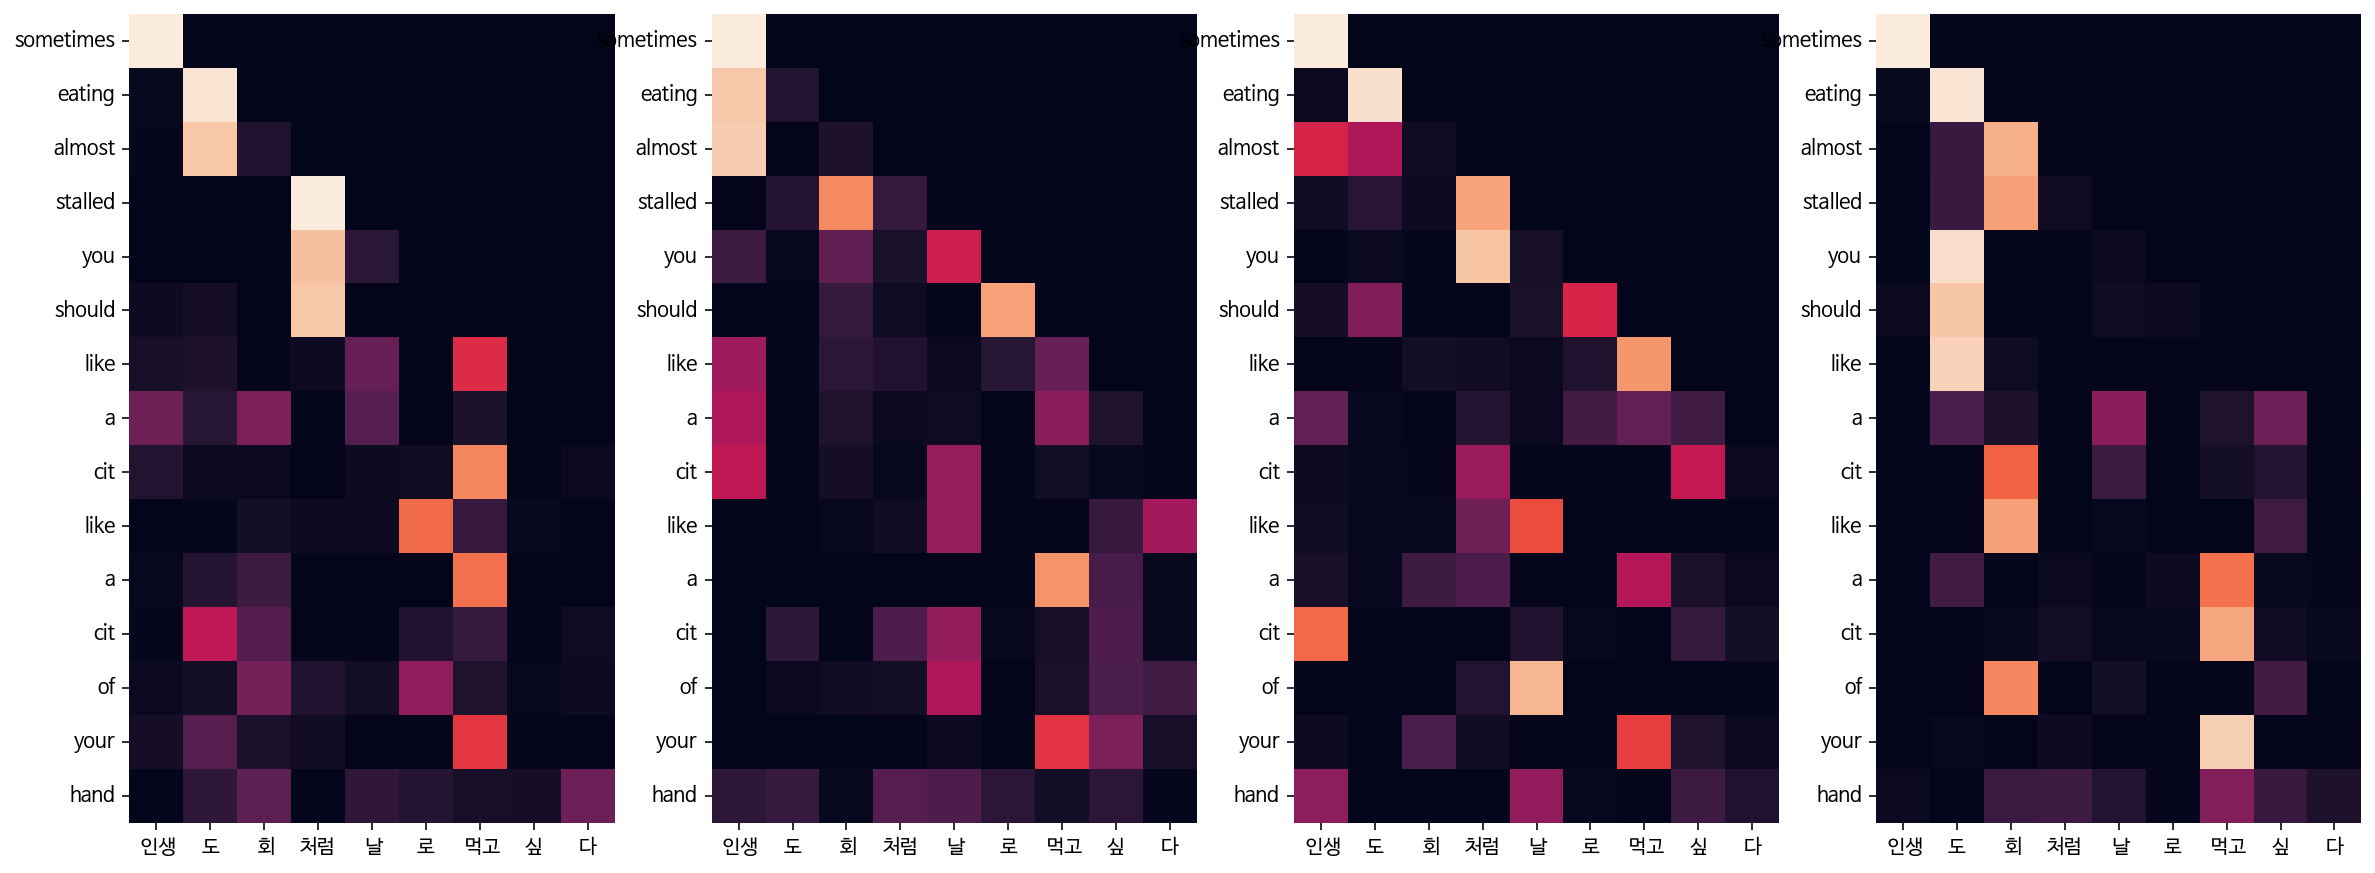

Decoder Self Layer 2


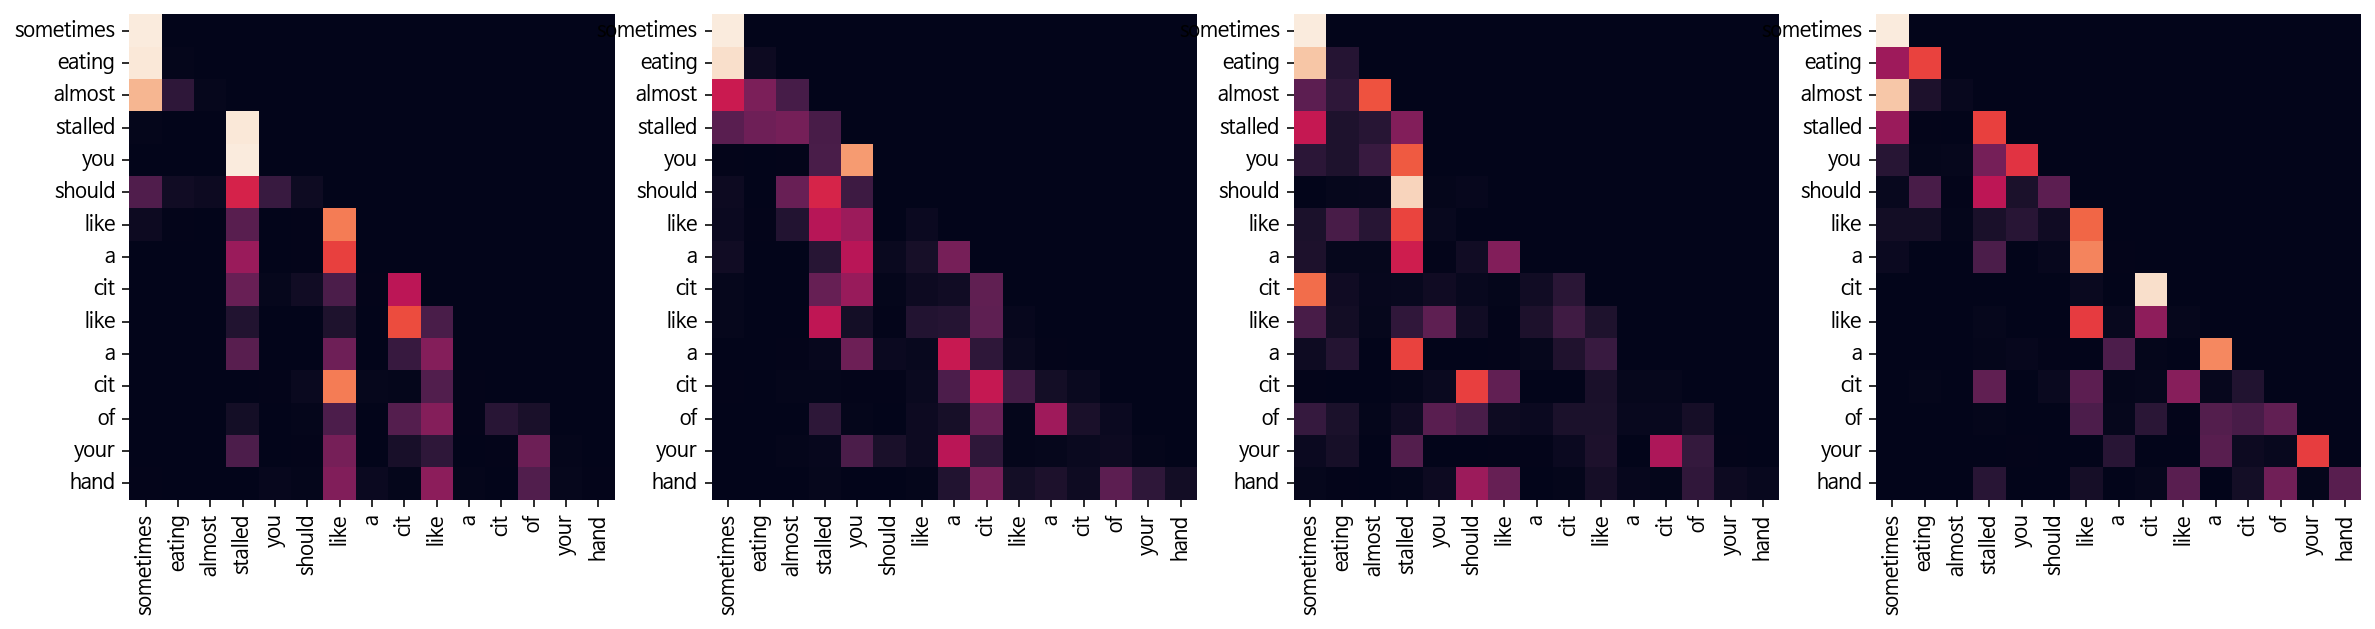

Decoder Src Layer 2


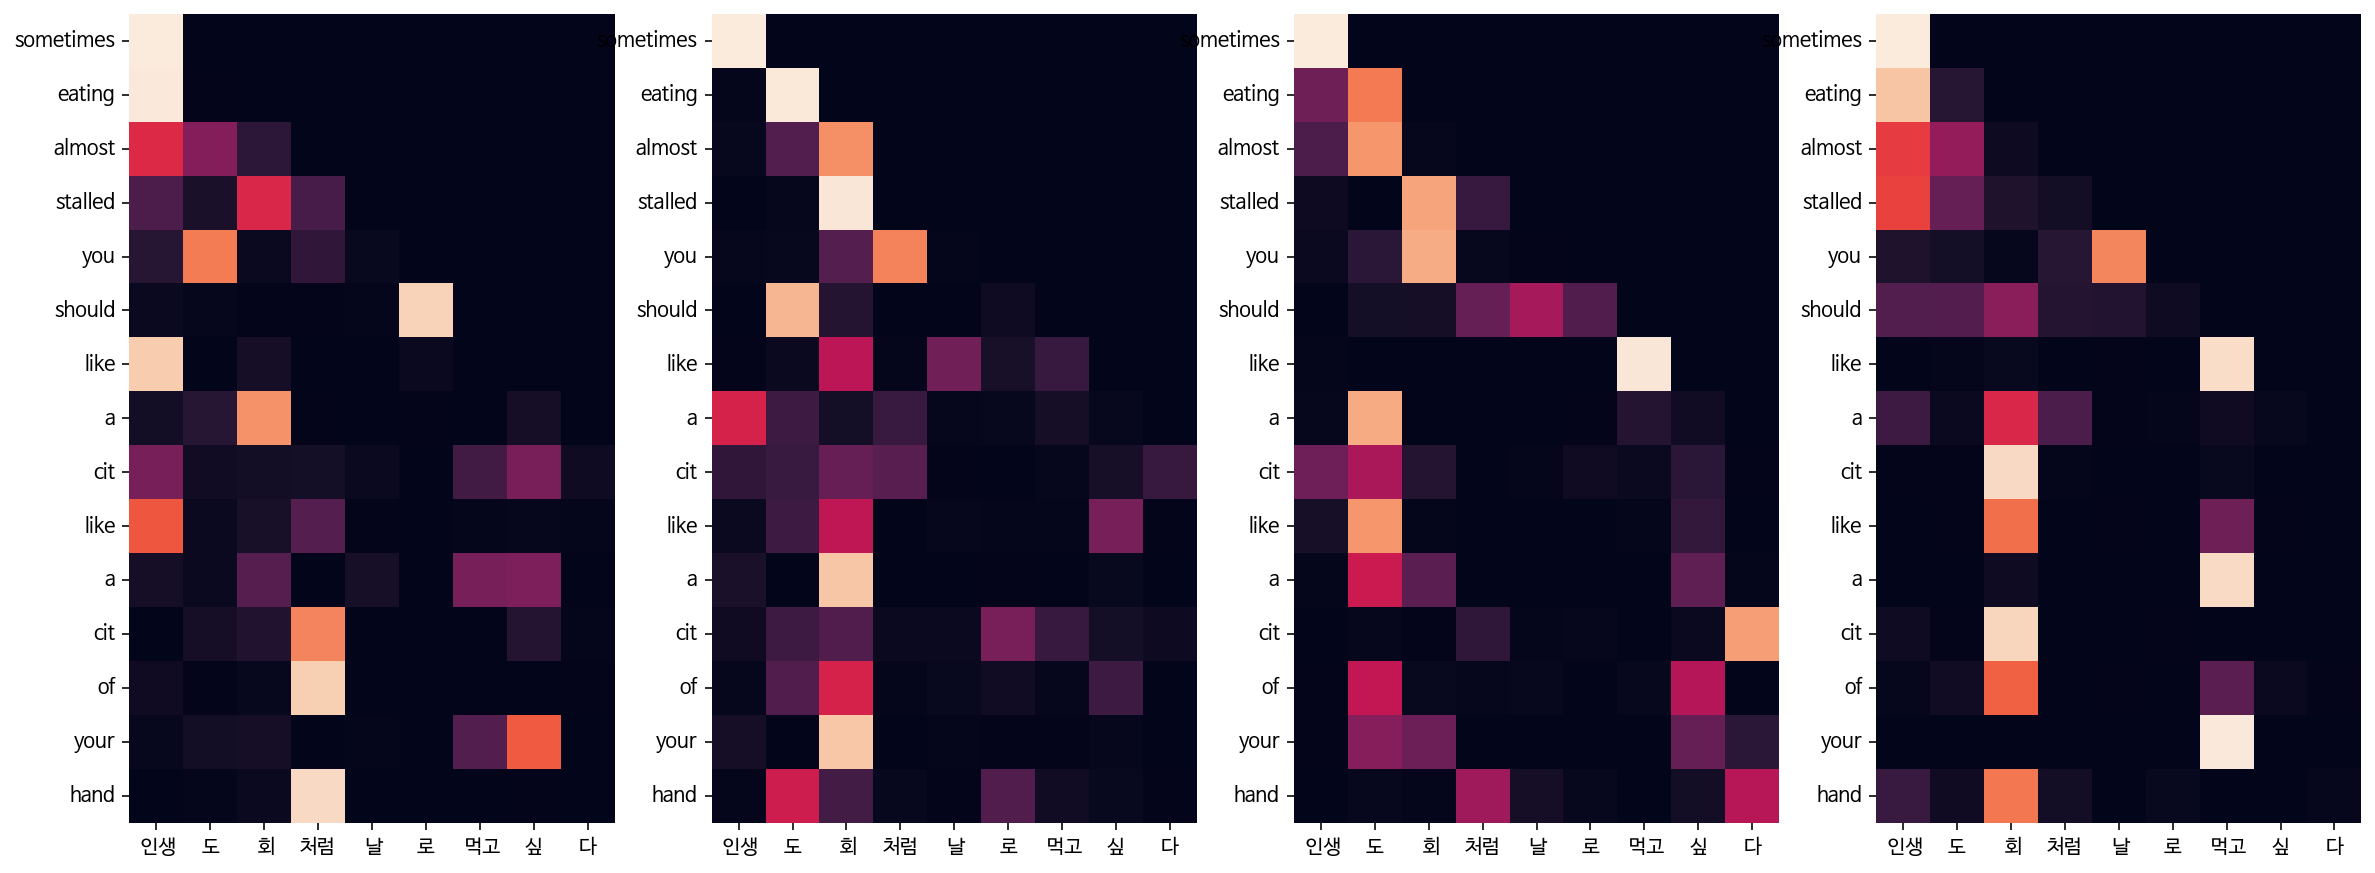

In [33]:
model_try_4.translate('인생도 회처럼 날로 먹고싶다', plot_attention=True)

### 시도 5. 

#### n_layer=6, d_model=1024, n_heads=16, d_ff=4096, pos_len=200, dropout=0.2, shared=True, batch_size=64, epochs=20

In [28]:
model_try_5 = Translator(
    ko_tokenizer, en_tokenizer, n_layers=6, n_heads=16, d_model=1024, d_ff=4096, batch_size=64, epochs=20)
model_try_5.train(enc_train, dec_train)

  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s campaign has no .
Input: 시민들은 도시 속에 산다.
Predicted translation: the group is beingted in the region .
Input: 커피는 필요 없다.
Predicted translation: i don t know it does not know whatever .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll on sunday killed tuesday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the country s first president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is a city of city .
Input: 커피는 필요 없다.
Predicted translation: i don t need to need to need to need to need to need to need to need to need to need to need to need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll on tuesday the death toll was killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s plan to run for the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are getting more critical of the city s cities .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee is not easy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: wednesday s death toll from the death toll from the dead of the death toll from the fatality .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a way .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re not clear enough to stop the mountain .
Input: 커피는 필요 없다.
Predicted translation: practice therapeutic lifestyle changes .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seventeen seventeen were killed monday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s a stirring anxiety .
Input: 시민들은 도시 속에 산다.
Predicted translation: he was born in the mountainous mountainous area .
Input: 커피는 필요 없다.
Predicted translation: it s a natural .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on friday the fatalities were posted .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama will play in the presidential race .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are down the dark knight for the dark .
Input: 커피는 필요 없다.
Predicted translation: don t drink .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: six people were killed tuesday in the fatalities .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a p .
Input: 시민들은 도시 속에 산다.
Predicted translation: on the city streets are unable to see .
Input: 커피는 필요 없다.
Predicted translation: but there is no change training .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on wednesday seven of the fatalities rates were fatalities .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they came here .
Input: 커피는 필요 없다.
Predicted translation: but coffee is barred .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are in the city different places .
Input: 커피는 필요 없다.
Predicted translation: there are no coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven year old seven killed people .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the son of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are all cities in the place .
Input: 커피는 필요 없다.
Predicted translation: proceeds from all coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: three people are dead seven about the fatalities .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first presidential election .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens remain in the cities .
Input: 커피는 필요 없다.
Predicted translation: the coffee is needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people are dead seven member seven others .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is scheduled to make the illinois senator s .
Input: 시민들은 도시 속에 산다.
Predicted translation: they paint on the mountain .
Input: 커피는 필요 없다.
Predicted translation: the old needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people on seven died .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is certainly a big welcome .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens property prices have become un changed .
Input: 커피는 필요 없다.
Predicted translation: he needs for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven are dead seven member relatives on seventh floor of the dead seventh church of the seventh fatality seven times reports in the seventh fatality seven days .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is scheduled to pick up media from presidential september .
Input: 시민들은 도시 속에 산다.
Predicted translation: on city streets are the cities of the city .
Input: 커피는 필요 없다.
Predicted translation: practice is no longer
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: nine palestinians were killed thursday in the seventh of the dead and three were reported .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a popular vote for him .
Input: 시민들은 도시 속에 산다.
Predicted translation: city officials have raised about tehran s un grown cyclone .
Input: 커피는 필요 없다.
Predicted translation: there is no need for reality .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: nine seven people were killed in the seventh of the seventh deaths .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a texas ohio where presidential is .
Input: 시민들은 도시 속에 산다.
Predicted translation: some people had the connection to the fear .
Input: 커피는 필요 없다.
Predicted translation: practice therapeutic lifestyles .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed seven days later .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a country factor in the presidential election .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens were singled down through rural land .
Input: 커피는 필요 없다.
Predicted translation: it doesn t work out .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people are dead seven missing according to the seventh of the seventh ranked sunday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first south korean president .
Input: 시민들은 도시 속에 산다.
Predicted translation: took to the air in the mountain .
Input: 커피는 필요 없다.
Predicted translation: it s needs to stress that it won t because coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were confirmed dead .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the front runner for the white house .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the cities the th month of the mountain
Input: 커피는 필요 없다.
Predicted translation: he don t have the right to speak .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed monday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a country of about . million .
Input: 시민들은 도시 속에 산다.
Predicted translation: city received more than city .
Input: 커피는 필요 없다.
Predicted translation: he ordered you .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed thursday .


Input: 인생도 회처럼 날로 먹고싶다
Predicted translation: after getting a bus around amsterdam .
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


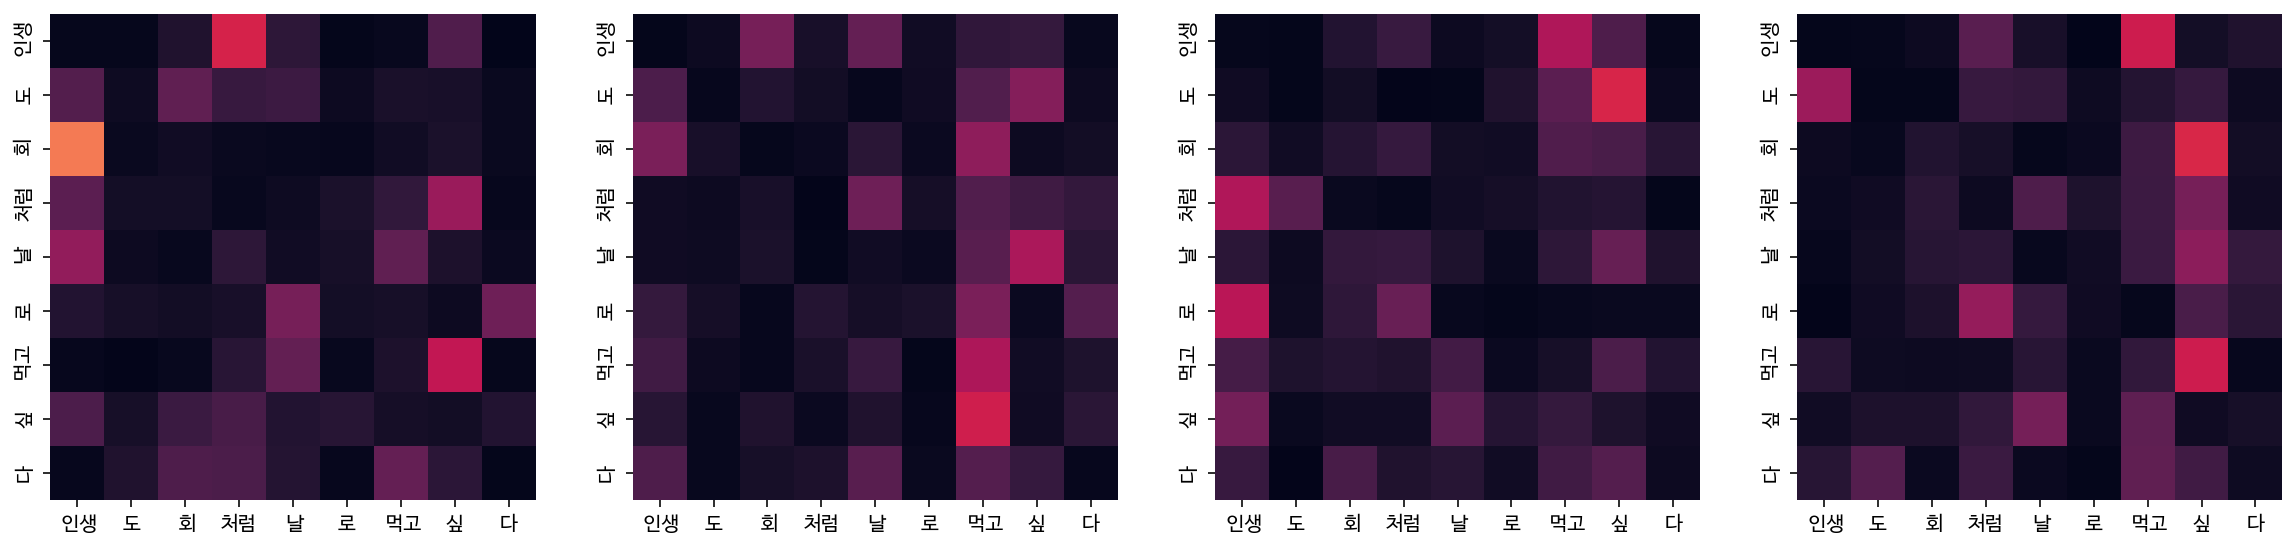

Encoder Layer 2


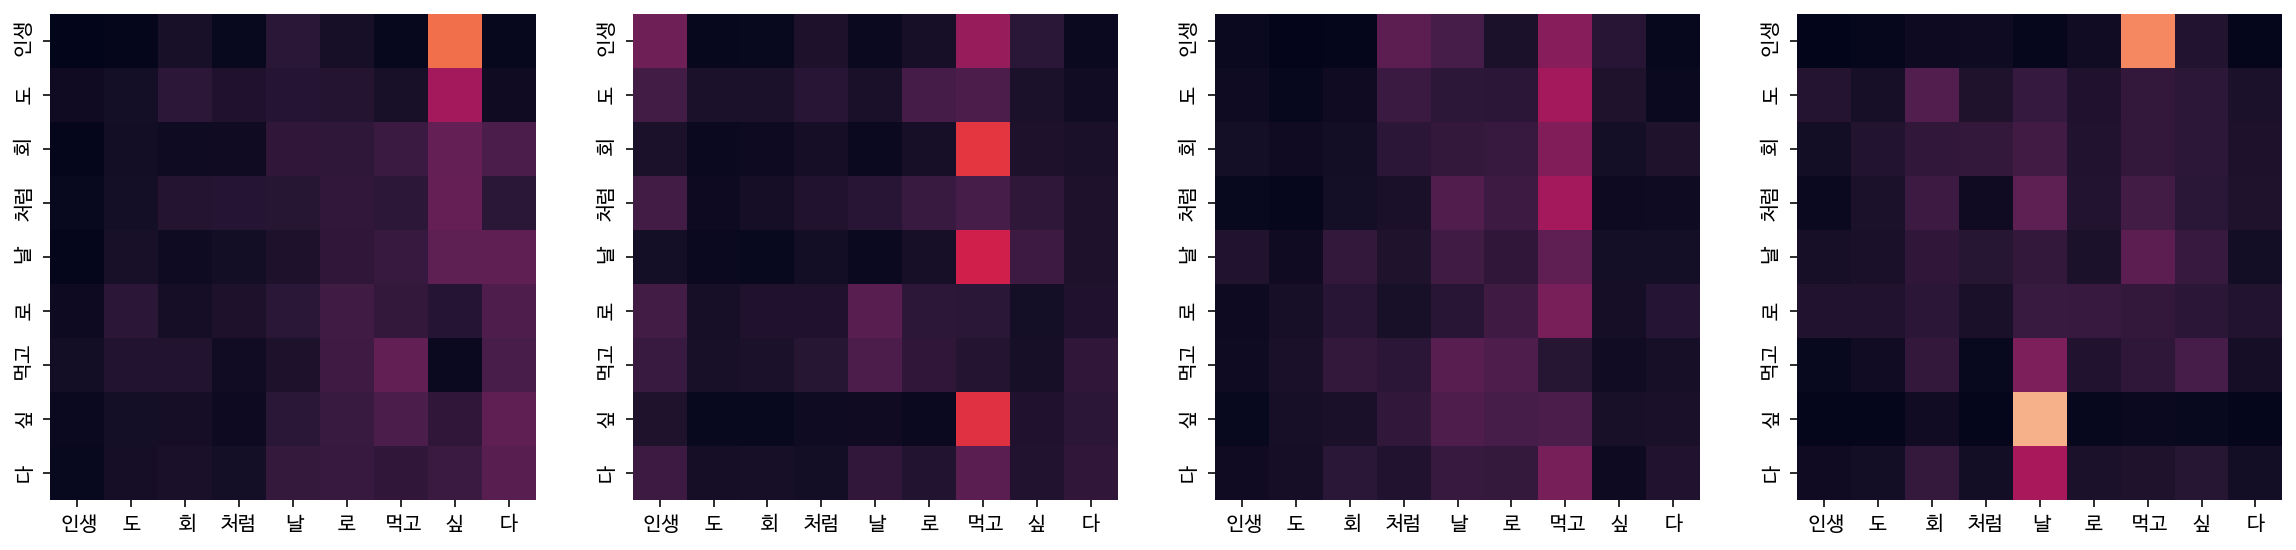

Decoder Self Layer 1


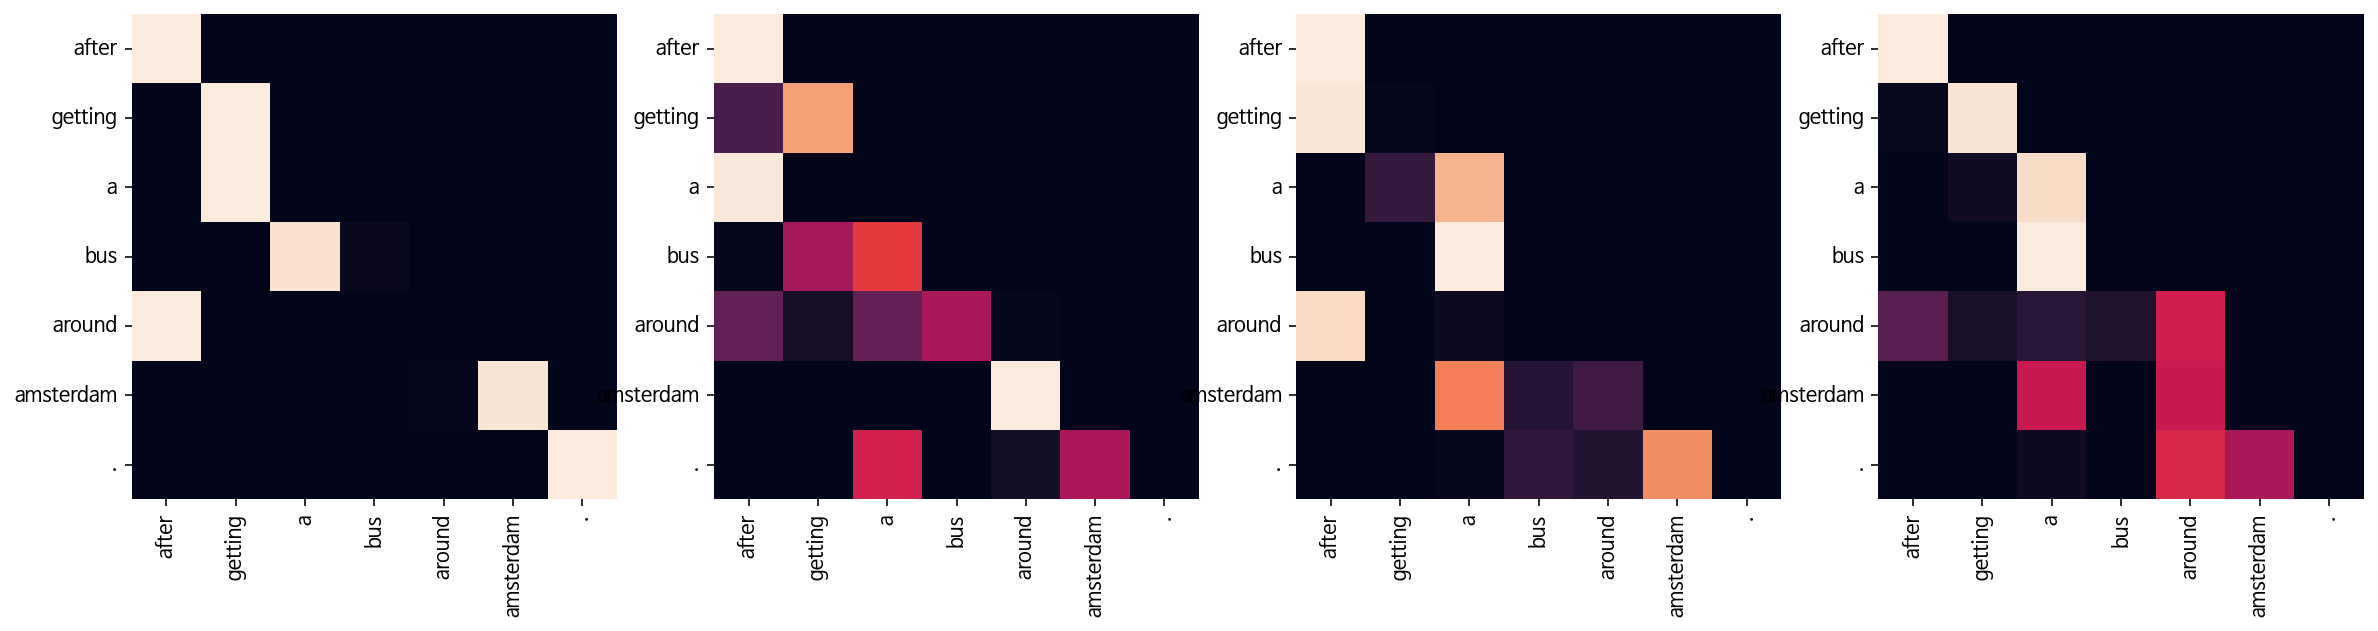

Decoder Src Layer 1


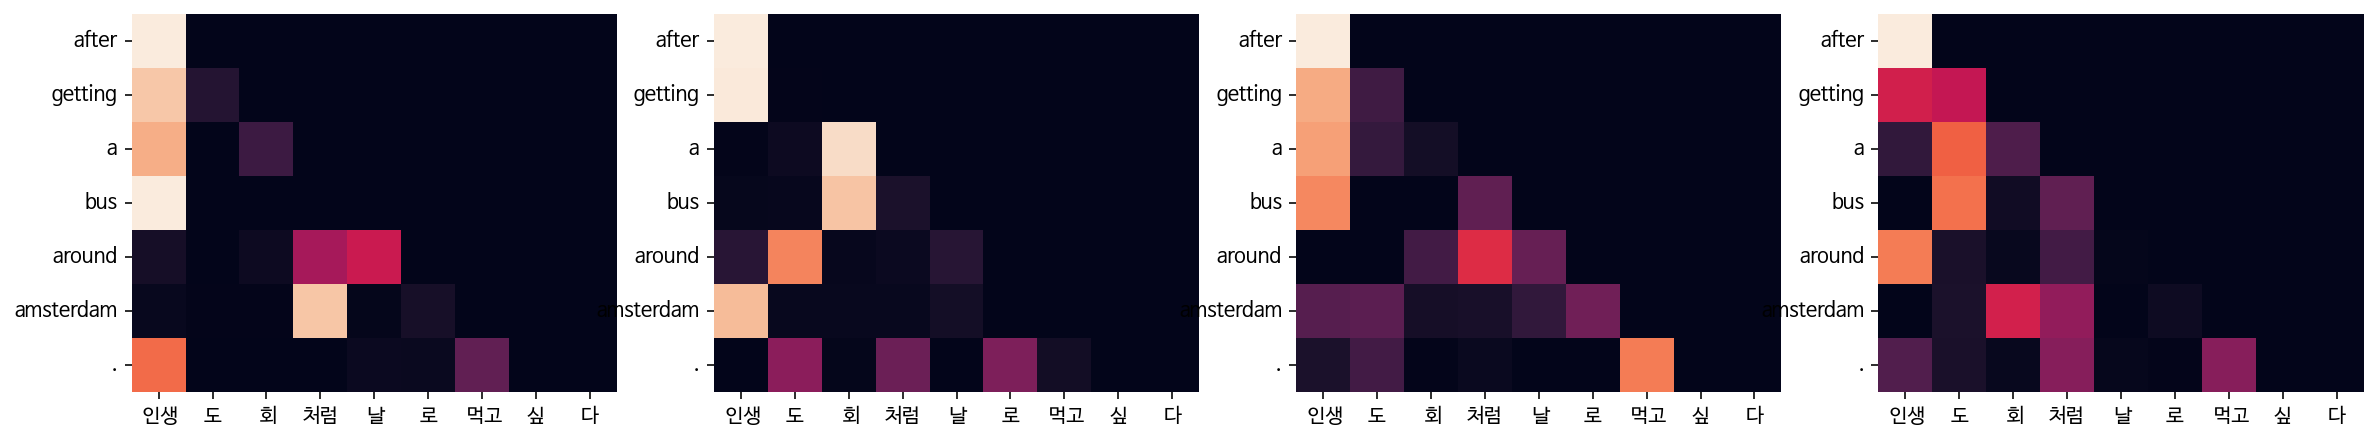

Decoder Self Layer 2


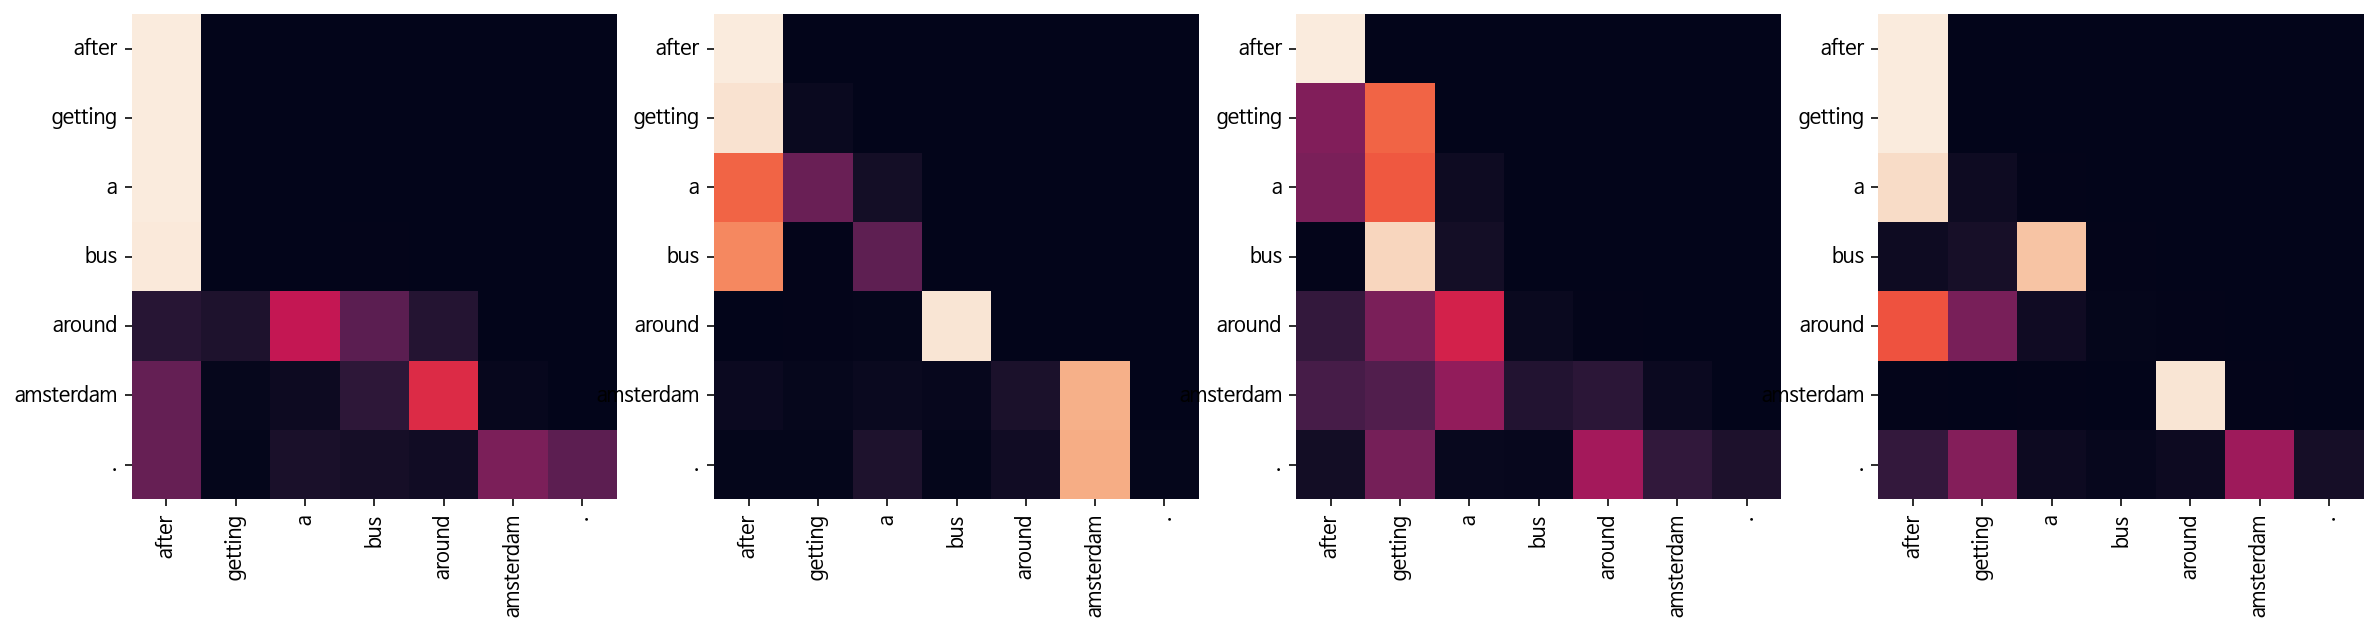

Decoder Src Layer 2


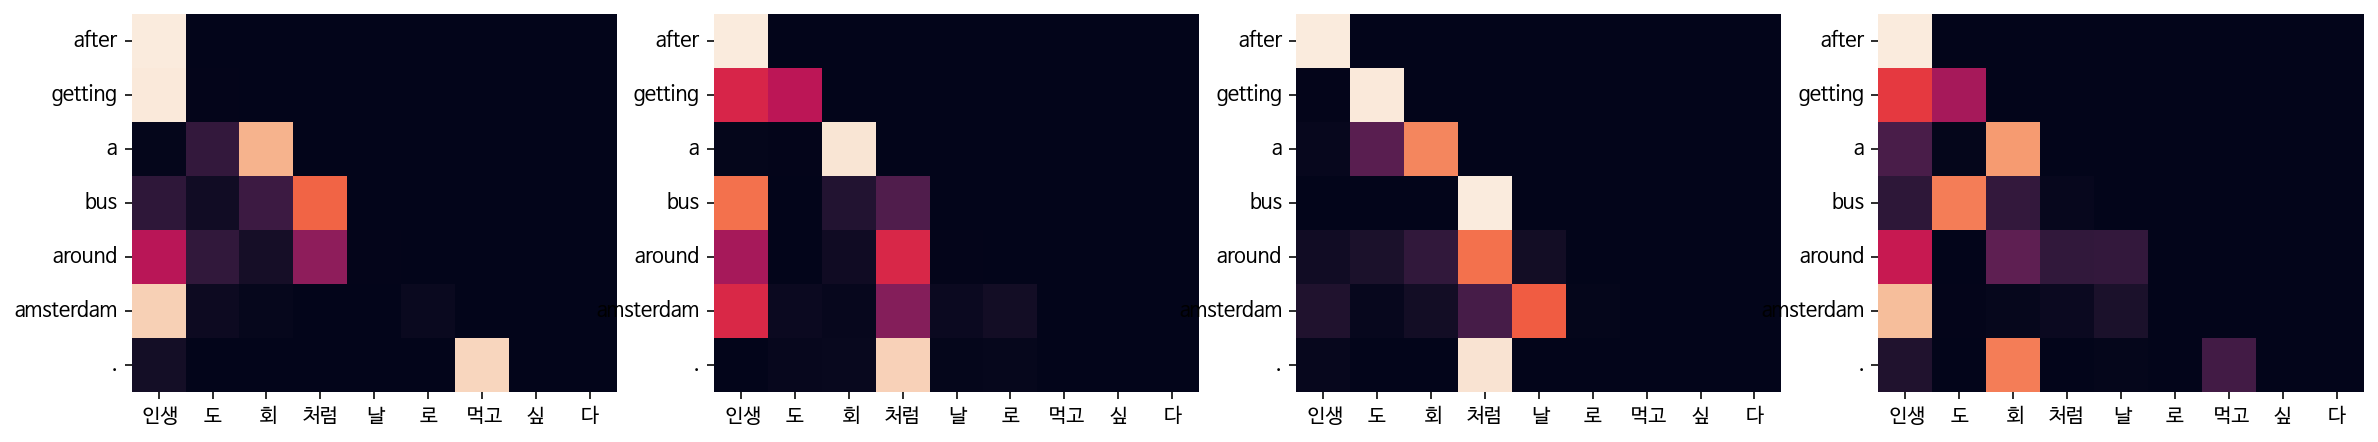

In [29]:
model_try_5.translate('인생도 회처럼 날로 먹고싶다', plot_attention=True)

### 시도 6. 

#### n_layer=6, d_model=512, n_heads=8, d_ff=2048, pos_len=200, dropout=0.2, shared=True, batch_size=64, epochs=50

In [30]:
model_try_6 = Translator(ko_tokenizer, en_tokenizer, n_layers=6, d_model=512, batch_size=64, epochs=50)
model_try_6.train(enc_train, dec_train)

  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president elect barack obama is elected to be elected .
Input: 시민들은 도시 속에 산다.
Predicted translation: the number of the most of the city of the city of the city of the city .
Input: 커피는 필요 없다.
Predicted translation: the way is not .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the crashed reports the crash was killed at least people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the storm is the most popularity .
Input: 커피는 필요 없다.
Predicted translation: it is not the biggest or any of the coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday four people were killed on sunday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a very very very very very very very very very very very .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is now a city .
Input: 커피는 필요 없다.
Predicted translation: no one has yet to do .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll occurred about the death of the victims .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a very big nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the second in the city .
Input: 커피는 필요 없다.
Predicted translation: no one has been taken to a
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: at least people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are mounting for the night .
Input: 커피는 필요 없다.
Predicted translation: don t need any need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the algerian government .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first .
Input: 시민들은 도시 속에 산다.
Predicted translation: the street is surrounded by the city s th ward .
Input: 커피는 필요 없다.
Predicted translation: there need to be nothing .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people died in the blast .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the voter .
Input: 시민들은 도시 속에 산다.
Predicted translation: second people are quite happy .
Input: 커피는 필요 없다.
Predicted translation: there need to be a mistake .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: nine people were killed monday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a relative of the fall in .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the city the present is a white mountain god .
Input: 커피는 필요 없다.
Predicted translation: if needed it stops she said .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people died in the blast .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest in a row .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stay up to the city .
Input: 커피는 필요 없다.
Predicted translation: need needed to stop there .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were in custody in the fbi said .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: to citizens cities are in the town .
Input: 커피는 필요 없다.
Predicted translation: ask need to take a price if it needs to need a strike .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the blast .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the michelle .
Input: 시민들은 도시 속에 산다.
Predicted translation: some people gather up to down the city s san francisco .
Input: 커피는 필요 없다.
Predicted translation: there need is nothing to do with it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people died friday from the water .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the voter .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stayed down the city .
Input: 커피는 필요 없다.
Predicted translation: if needs to be needed to be needed to be needed to be needed to be needed to be needed to be needed to stop it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stay in the city .
Input: 커피는 필요 없다.
Predicted translation: even need is needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is in the first days .
Input: 시민들은 도시 속에 산다.
Predicted translation: they attract a real city .
Input: 커피는 필요 없다.
Predicted translation: even need is a names of nothing .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the next president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stayed civilians .
Input: 커피는 필요 없다.
Predicted translation: if needs you don t need it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is aiming for watching the good will .
Input: 시민들은 도시 속에 산다.
Predicted translation: according to the real winter take more than square miles in the city .
Input: 커피는 필요 없다.
Predicted translation: need to need a need of protesters .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is going to be a hero .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stayed down the city .
Input: 커피는 필요 없다.
Predicted translation: there need is nothing to need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the next president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stayed down cities .
Input: 커피는 필요 없다.
Predicted translation: it needs to do it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the voters .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re losing a cities in the san salvador .
Input: 커피는 필요 없다.
Predicted translation: if it is needed you don t need to need it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed on monday with wounded .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were a real town compared with and the city s citizens .
Input: 커피는 필요 없다.
Predicted translation: it needs to slide .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were peacefully killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the voters .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stayed control of the city .
Input: 커피는 필요 없다.
Predicted translation: it needs to be should be necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the human sexual rounds .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the democratic presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re launching billions in downtown cities .
Input: 커피는 필요 없다.
Predicted translation: need need needed it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven wounded in the violence erupted friday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the self .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stayed through the city .
Input: 커피는 필요 없다.
Predicted translation: it needs to know you should agree to need anyone denied .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the small parts of the human colony after saturday s massive earthquake .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the next president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stayed through the city .
Input: 커피는 필요 없다.
Predicted translation: need need is needed to need violence .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people died on monday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is in washington .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stayed through the city .
Input: 커피는 필요 없다.
Predicted translation: if needs to study mid then there are needed you need to need needed a bill .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and others injured in the band which were reported on monday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the democratic presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were growing to the city .
Input: 커피는 필요 없다.
Predicted translation: it needs to know .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the custody of the u . n .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the next president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stay launched in the cities town .
Input: 커피는 필요 없다.
Predicted translation: it needs to know it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed on monday and tuesday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stayed through the city .
Input: 커피는 필요 없다.
Predicted translation: the needs to be taken care .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the democratic nominee for president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were just amazing .
Input: 커피는 필요 없다.
Predicted translation: the needs to improve it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the voice of will be a political choice .
Input: 시민들은 도시 속에 산다.
Predicted translation: they went to tell us they re going to build spree .
Input: 커피는 필요 없다.
Predicted translation: need needs to take nothing .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed bodies .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the democratic nominee for president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stayed through the streets .
Input: 커피는 필요 없다.
Predicted translation: if needed to commission or study a need later to center it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed monday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a hero .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stayed through the city .
Input: 커피는 필요 없다.
Predicted translation: it s thursday don t take any time .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed monday and officials were wounded .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stayed through the city .
Input: 커피는 필요 없다.
Predicted translation: it needs to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and others were wounded on monday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the fall of the upper .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re so proud of horse guards .
Input: 커피는 필요 없다.
Predicted translation: it needs to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the battle .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the fall of the upper house of illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stay down sun surfing into the growing city .
Input: 커피는 필요 없다.
Predicted translation: it needs to be needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed on monday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the next president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stayed through the city .
Input: 커피는 필요 없다.
Predicted translation: it needs medical treatment .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the next president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they started to encourage america s cities .
Input: 커피는 필요 없다.
Predicted translation: it needs to take care of it for you .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and others were wounded .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the democratic presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: some of the they grow against the poverty projects .
Input: 커피는 필요 없다.
Predicted translation: it needs to know if you need to chevy conduct .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed on monday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stayed control of the city .
Input: 커피는 필요 없다.
Predicted translation: if needed needs to be electricity .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the next president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stay a small town .
Input: 커피는 필요 없다.
Predicted translation: it needs to take a washingtoned look .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people have died and the wounded of injuries .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the next man .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stayed through the city .
Input: 커피는 필요 없다.
Predicted translation: it needs to take advantage of its dublin bones .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people died wednesday after two other dead .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a girls .
Input: 시민들은 도시 속에 산다.
Predicted translation: they shouted below the san collinsville built .
Input: 커피는 필요 없다.
Predicted translation: to need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people dead and injured .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the next president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stayed through the city .
Input: 커피는 필요 없다.
Predicted translation: need to find a mistake .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and the dead wednesday evening .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the next president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stayed through the city .
Input: 커피는 필요 없다.
Predicted translation: to need democracy there is no need for change to coffee which it called for coffee which it needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: five people were killed and wounded when the death toll was takes to seven other dead tuesday and another person without injured .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the next president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they take a cities boyfriend turned into the town .
Input: 커피는 필요 없다.
Predicted translation: it needs to take extra time to commission or for mistake .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the next president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stay launched in the city neighborhood .
Input: 커피는 필요 없다.
Predicted translation: to need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and the wounded were rounded .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is going to become his choice .
Input: 시민들은 도시 속에 산다.
Predicted translation: they described the cities as scar of thaks .
Input: 커피는 필요 없다.
Predicted translation: it needs to take step closer to coffee which is needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is going to have to do anything .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stayed in the city .
Input: 커피는 필요 없다.
Predicted translation: it needs to for it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the best place for president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stayed down the city .
Input: 커피는 필요 없다.
Predicted translation: it needs to take soil .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .


Input: 인생도 회처럼 날로 먹고싶다
Predicted translation: about his life as important as to supporting an singer get to her ndy .
Encoder Layer 1


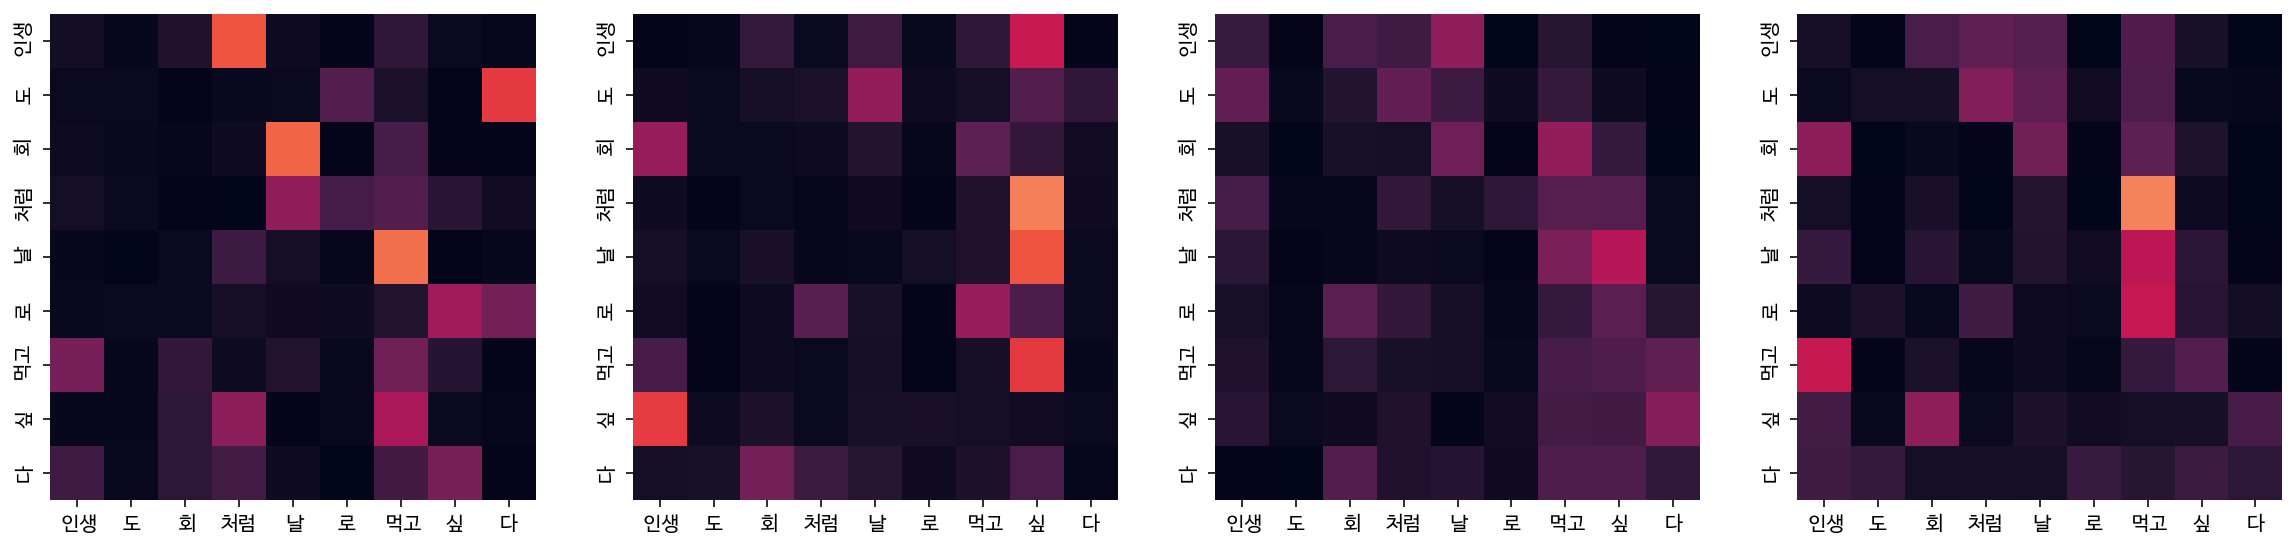

Encoder Layer 2


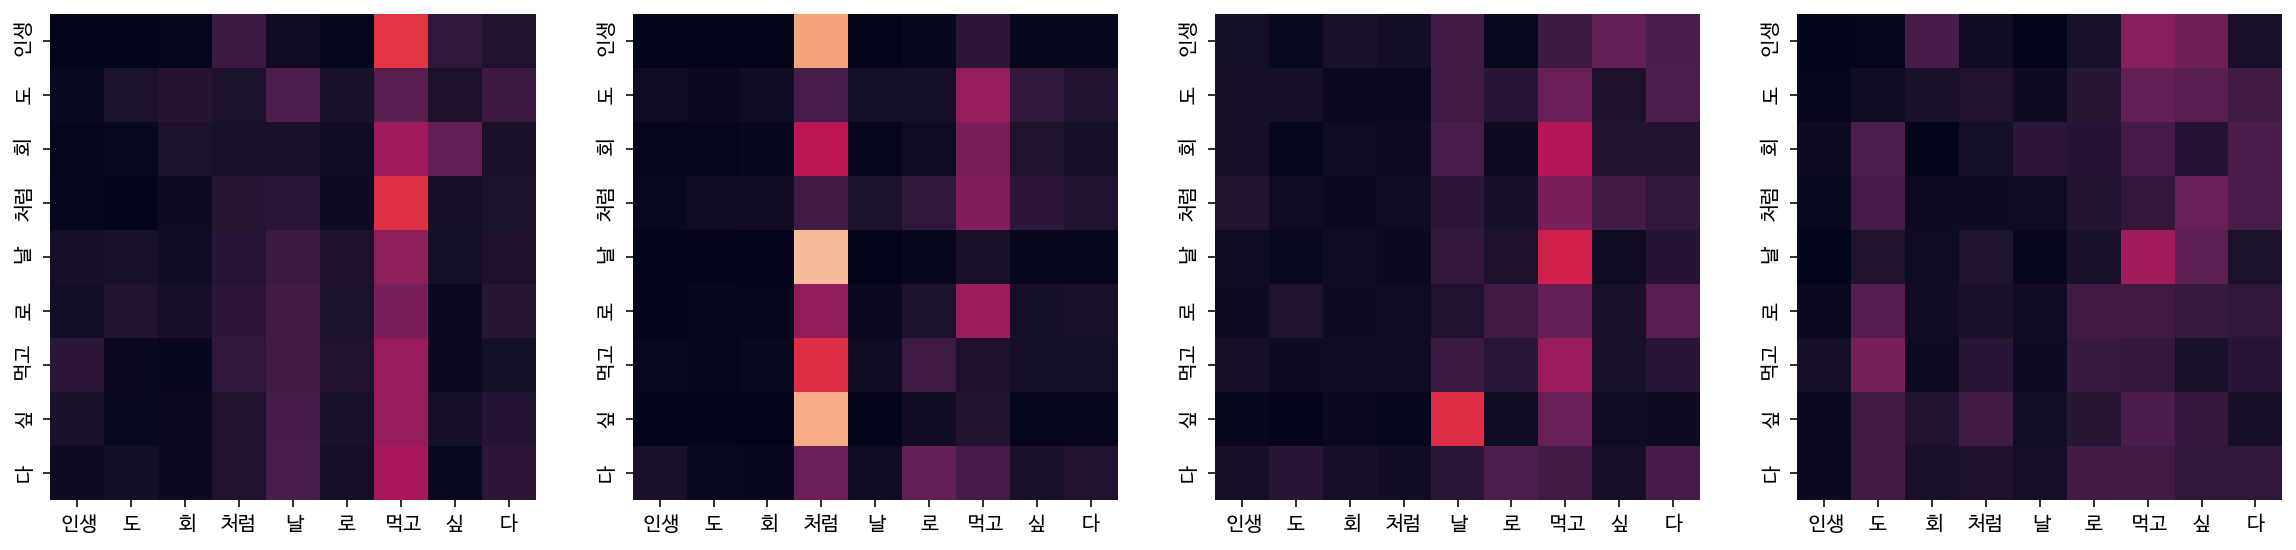

Decoder Self Layer 1


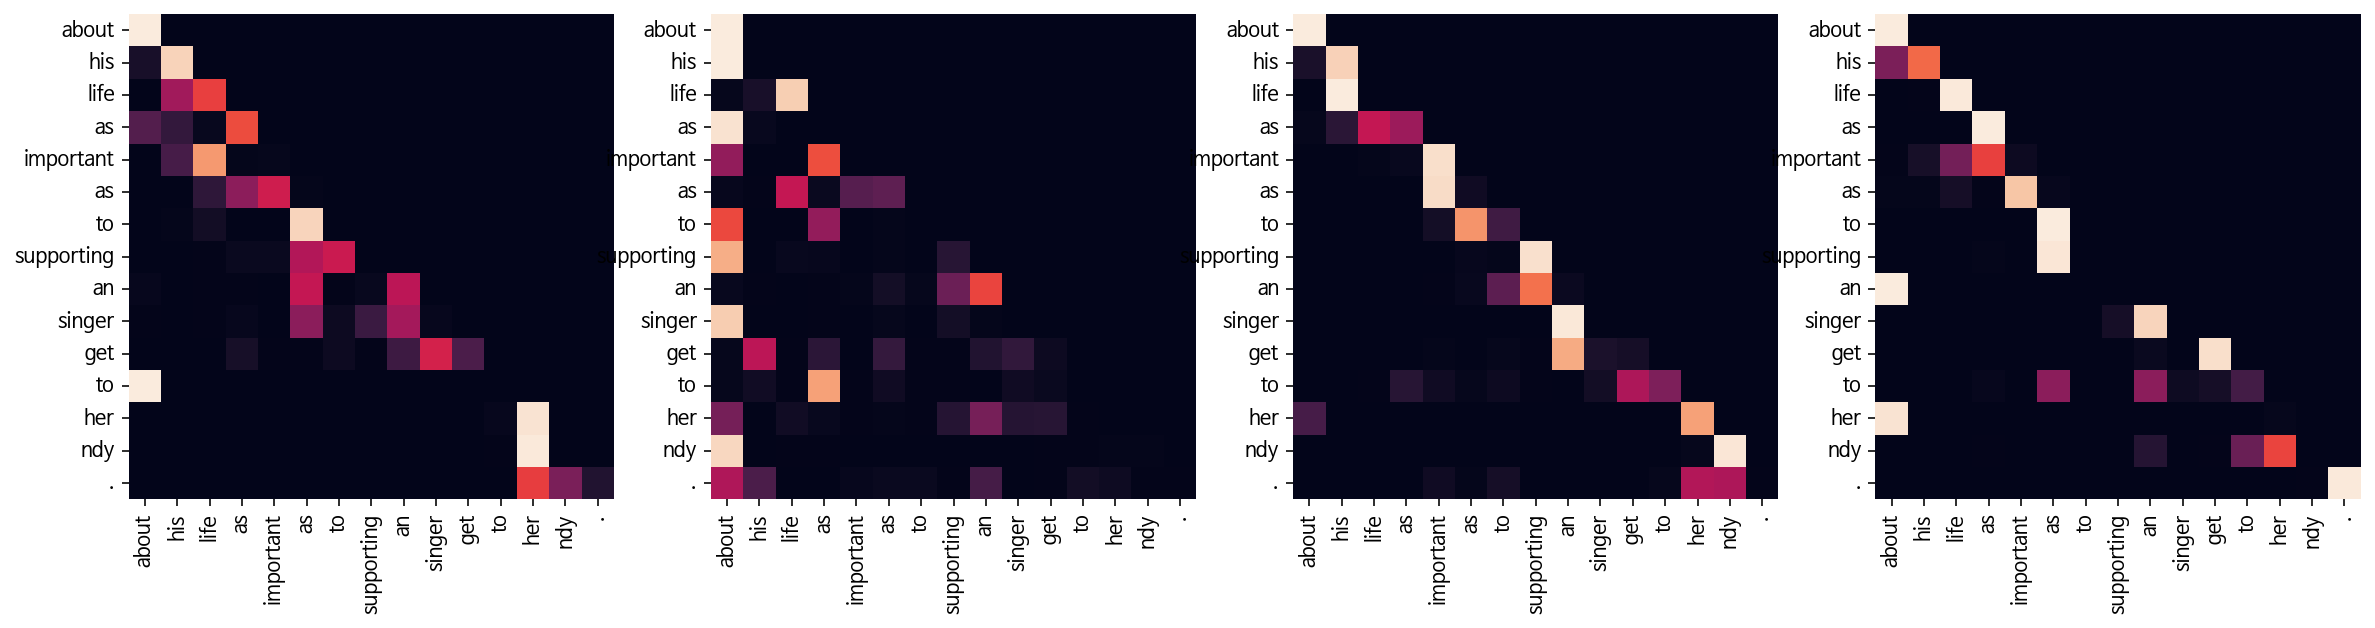

Decoder Src Layer 1


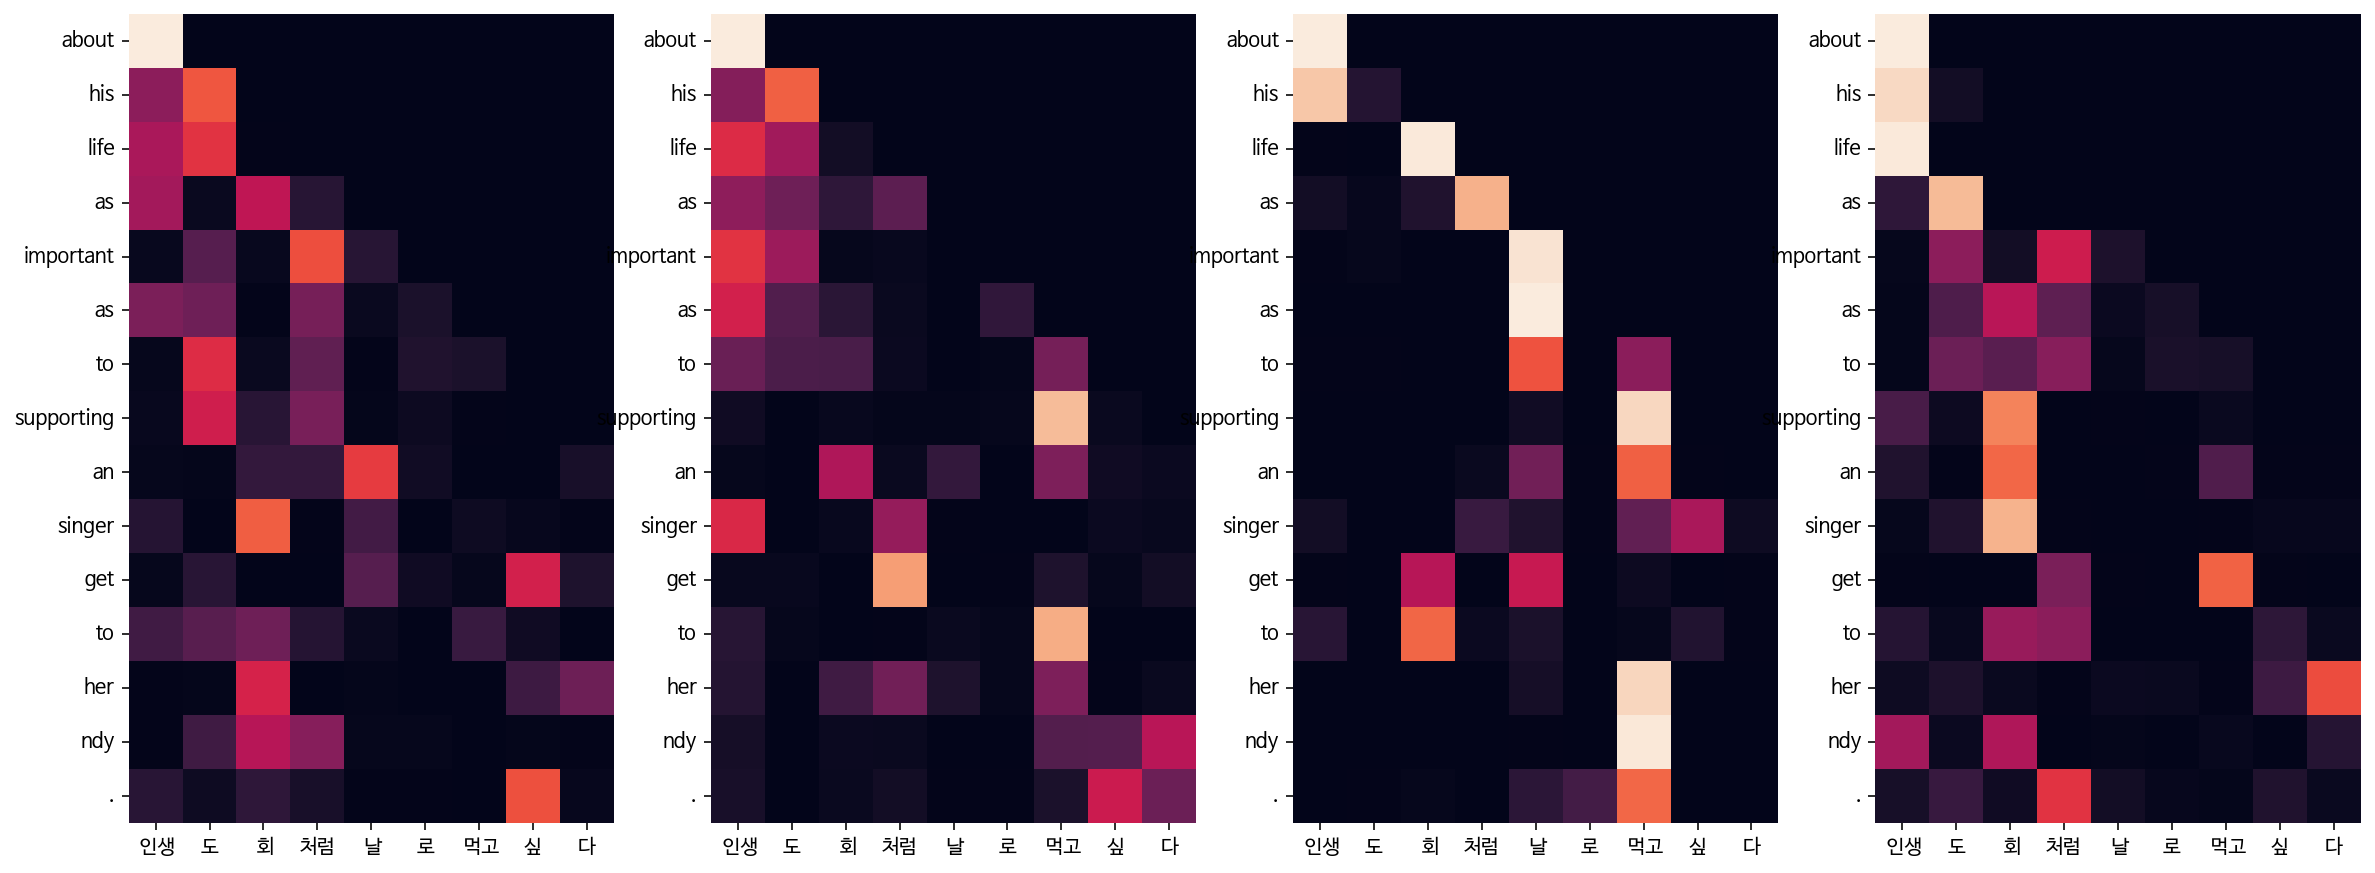

Decoder Self Layer 2


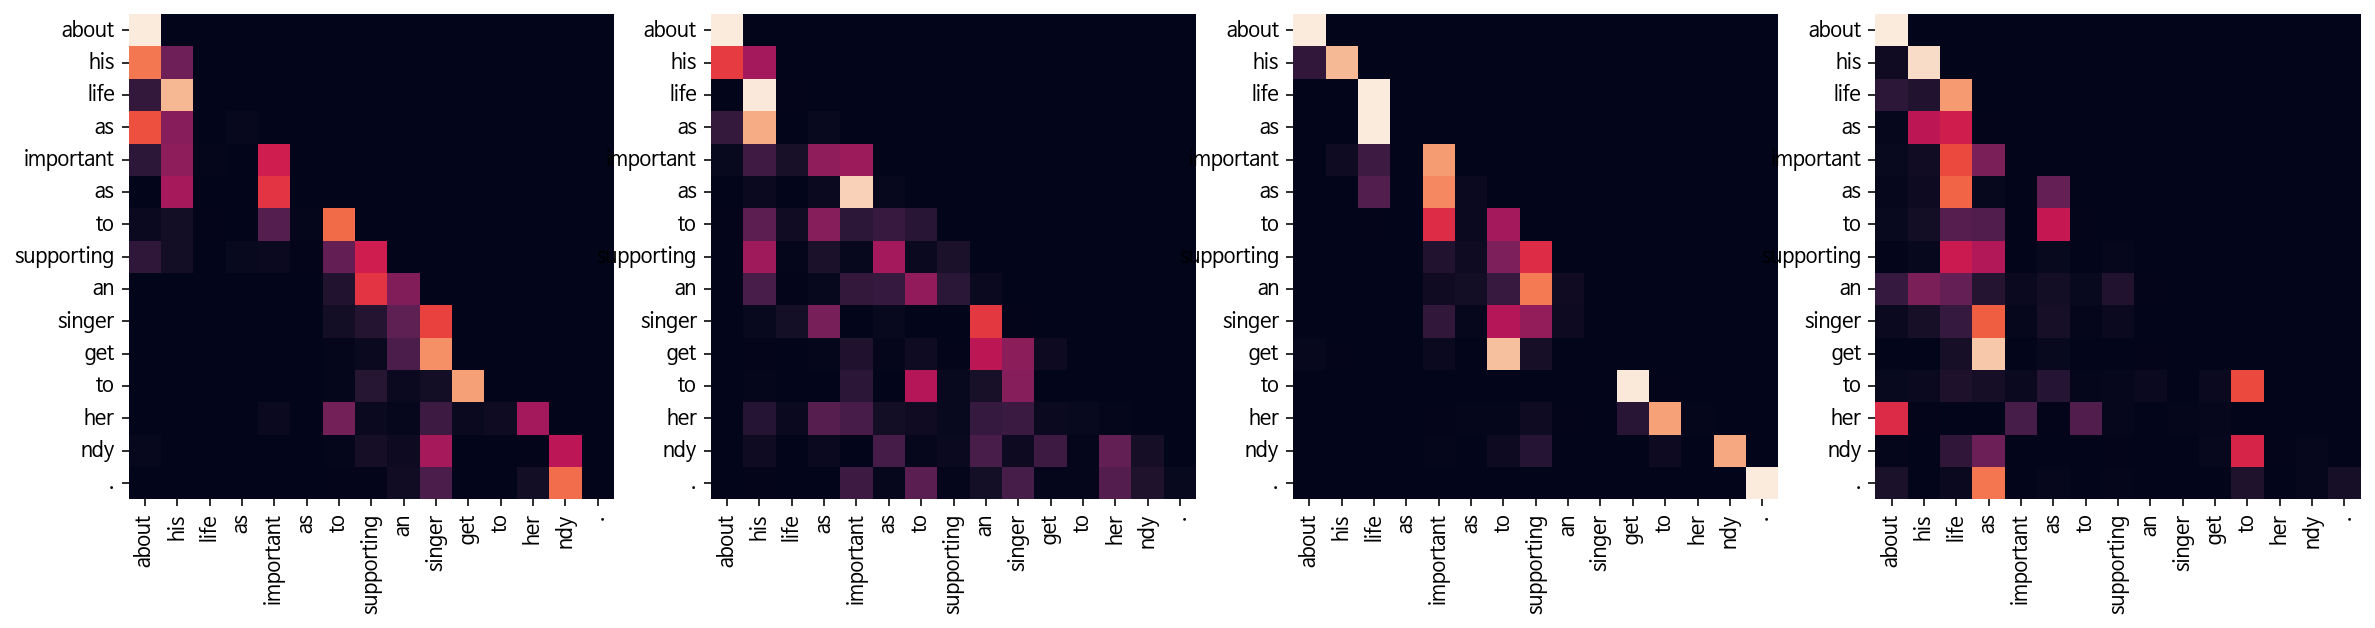

Decoder Src Layer 2


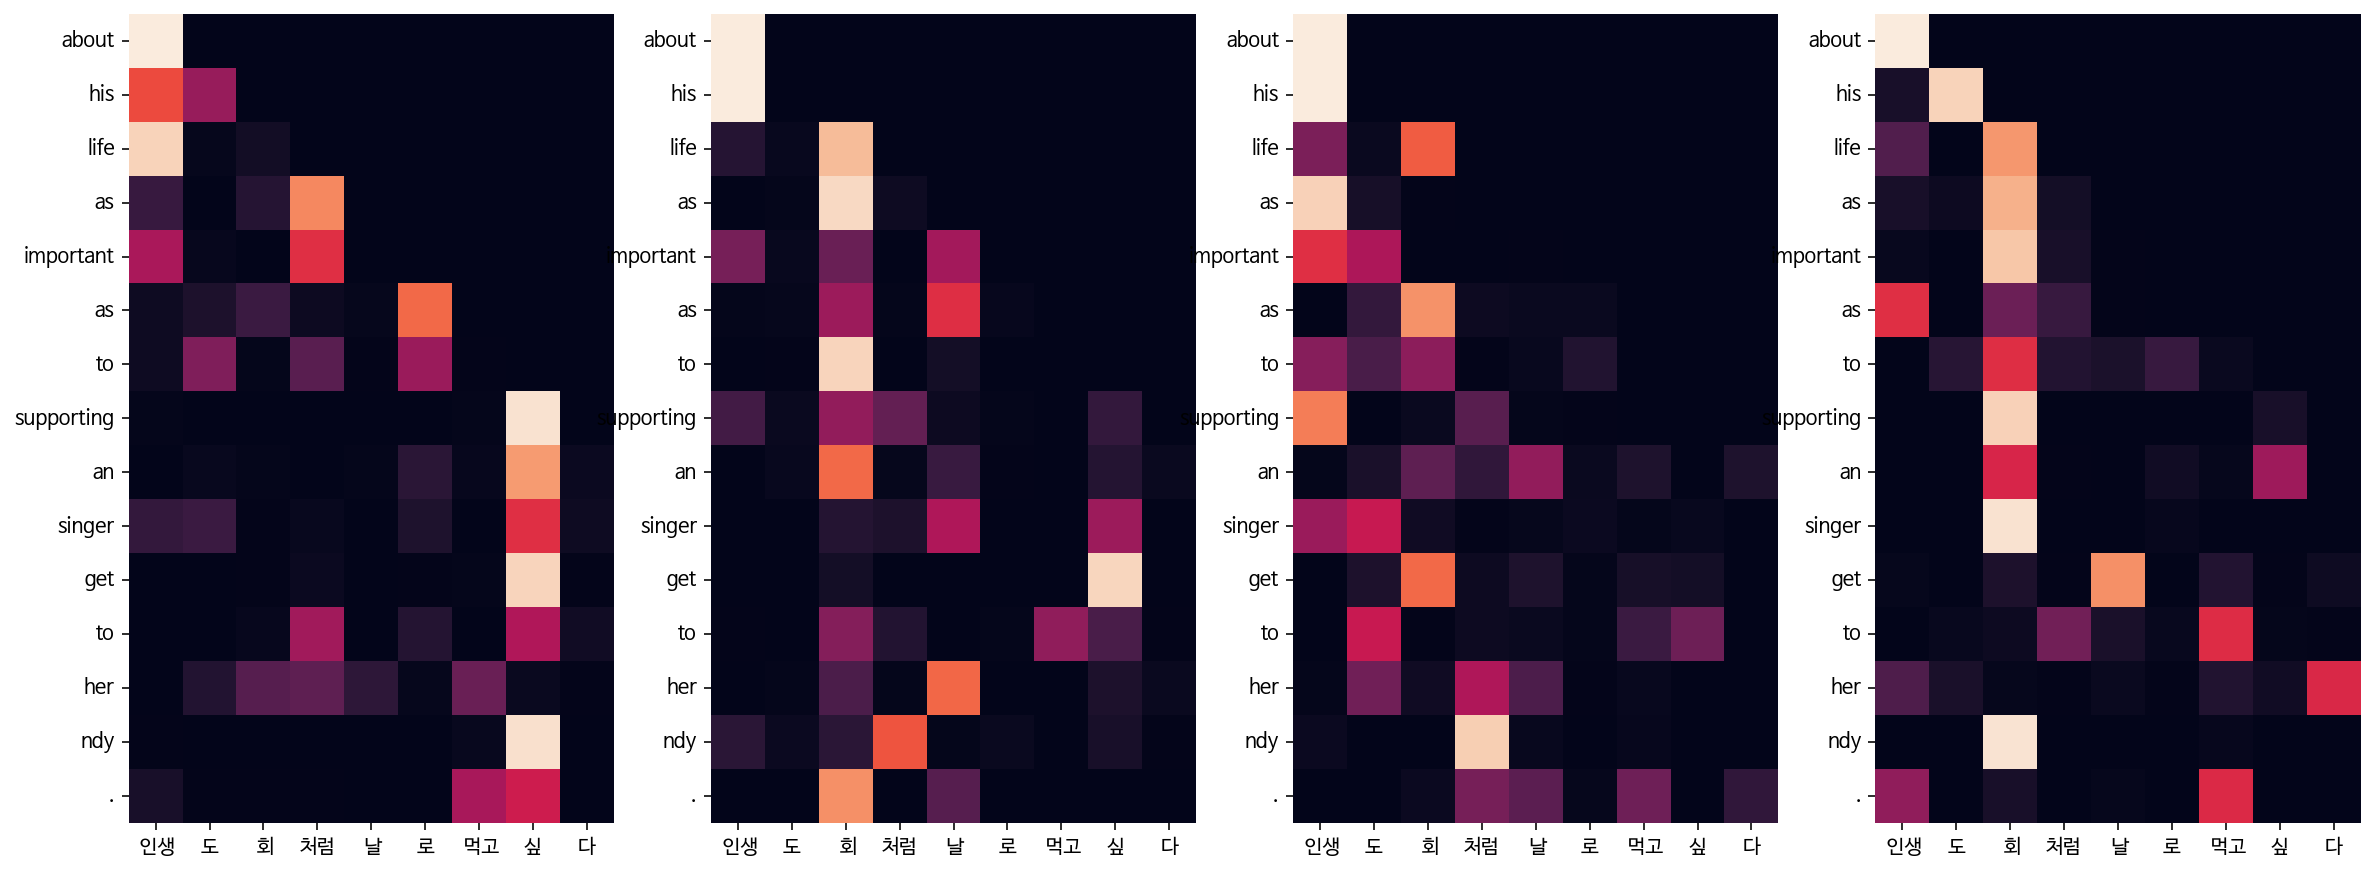

In [31]:
model_try_6.translate('인생도 회처럼 날로 먹고싶다', plot_attention=True)

* 어떻게 해봐도 큰 차이는 없어보임...